#  TOM / ROM Effect 분석 

-  월초/월말효과가 과연 존재한다면, 여기에 영향을 주는 요인은 무엇일까? 

> ***월말 월초효과(Turn of the Month Effect) 현상을 활용한 투자 전략에 관한 연구*** 의 인사이트 참고

-------


### cf) 월말 월초효과(Turn of the Month Effect, TOM)       
월말과 월초 기간에 유의적인 초과수익이 발생하는 현상이며, 월초와 월말에 발생하는 금융계의 이상현상중 하나임


------------

### Data Columns
1. 환율
2. 거래량
3. 투자자별 거래대금
4. 투자자 예탁금
5. 외국인 시가총액
6. 국내기간 자금 유출입
7. 신용거래 융자 잔고

In [1]:
# library load
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# data load
dt1 = pd.read_csv('환율.csv', encoding='cp949', thousands = ',')
dt2 = pd.read_csv('거래량.csv', encoding='cp949', thousands = ',')
dt3 = pd.read_csv('투자자별거래대금.csv', encoding='utf-8', thousands = ',')
dt4 = pd.read_csv('투자자예탁금.csv', encoding='utf-8', thousands = ',')
dt5 = pd.read_csv('외국인시가총액.csv', encoding='cp949', thousands = ',')
dt6 = pd.read_csv('국내기간자금유출입.csv', encoding='utf-8', thousands = ',')
dt7 = pd.read_csv('신용거래융자잔고.csv', encoding='utf-8', thousands = ',')

In [52]:
# 한글 폰트 설정
import platform
platform.system()
# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [2]:
# merge를 위해 datetime 형태로 날짜를 변환
dt1['date'] = pd.to_datetime(dt1['date'])
dt2['date'] = pd.to_datetime(dt2['date'])
dt3['date'] = pd.to_datetime(dt3['날짜'])
dt4['date'] = pd.to_datetime(dt4['구 분'])
dt5['date'] = pd.to_datetime(dt5['date'])
dt6['date'] = pd.to_datetime(dt6['Unnamed: 0'])
dt7['date'] = pd.to_datetime(dt7['일자'])

In [4]:
print(dt1.shape, dt2.shape, dt3.shape, dt4.shape, dt5.shape, dt6.shape, dt7.shape)

(6667, 2) (6667, 2) (4515, 6) (5855, 3) (3491, 3) (3536, 5) (3536, 3)


외국인 시가총액 데이터때문에 2007년부터 분석을 진행해야 할 것 같음

In [5]:
dt5.tail()

,date,외국인_시가총액,외국인 비중
3486,2007-01-08,2506114,37.19
3487,2007-01-05,2532473,37.18
3488,2007-01-04,2553242,37.18
3489,2007-01-03,2579421,37.24
3490,2007-01-02,2631666,37.31


In [6]:
# data merge
d1 = pd.merge(dt1, dt2, on='date')
d2 = pd.merge(dt3, dt4, on='date')
d3 = pd.merge(dt5, dt6, on='date')
d4 = pd.merge(d1, d2, on='date')
d5 = pd.merge(d4, d3, on='date')
final = pd.merge(d5, dt7, on='date')

# 불필요한 칼럼 제거
final.drop(['날짜', '구 분', 'Unnamed: 0', '일자'], axis=1, inplace=True)

In [7]:
final.columns

Index(['date', '환율', '거래량', '기관합계', '기타법인', '개인', '외국인합계', '투자자예탁금',
       '외국인_시가총액', '외국인 비중', '기간자금설정', '기간자금해지', '증감', '유가증권신용거래융자'],
      dtype='object')

In [8]:
final.shape   # 2007년부터 현재까지 약 3490개정도 데이터

(3490, 14)

# EDA

In [9]:
final.head(2)

,date,환율,거래량,기관합계,기타법인,개인,외국인합계,투자자예탁금,외국인_시가총액,외국인 비중,기간자금설정,기간자금해지,증감,유가증권신용거래융자
0,2007-01-02,929.6,14430.0,-49479494305,0,30058872445,19420621860,8561691.0,2631666,37.31,27941,41180,-13239,333970
1,2007-01-03,926.0,19080.0,-89720793350,0,145826577680,-56105784330,8918052.0,2579421,37.24,24504,25611,-1108,335226


In [10]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3490 entries, 0 to 3489
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        3490 non-null   datetime64[ns]
 1   환율          3490 non-null   float64       
 2   거래량         3486 non-null   float64       
 3   기관합계        3490 non-null   int64         
 4   기타법인        3490 non-null   int64         
 5   개인          3490 non-null   int64         
 6   외국인합계       3490 non-null   int64         
 7   투자자예탁금      3490 non-null   float64       
 8   외국인_시가총액    3490 non-null   int64         
 9   외국인 비중      3490 non-null   float64       
 10  기간자금설정      3490 non-null   int64         
 11  기간자금해지      3490 non-null   int64         
 12  증감          3490 non-null   int64         
 13  유가증권신용거래융자  3490 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(9)
memory usage: 409.0 KB


In [11]:
final.columns

Index(['date', '환율', '거래량', '기관합계', '기타법인', '개인', '외국인합계', '투자자예탁금',
       '외국인_시가총액', '외국인 비중', '기간자금설정', '기간자금해지', '증감', '유가증권신용거래융자'],
      dtype='object')

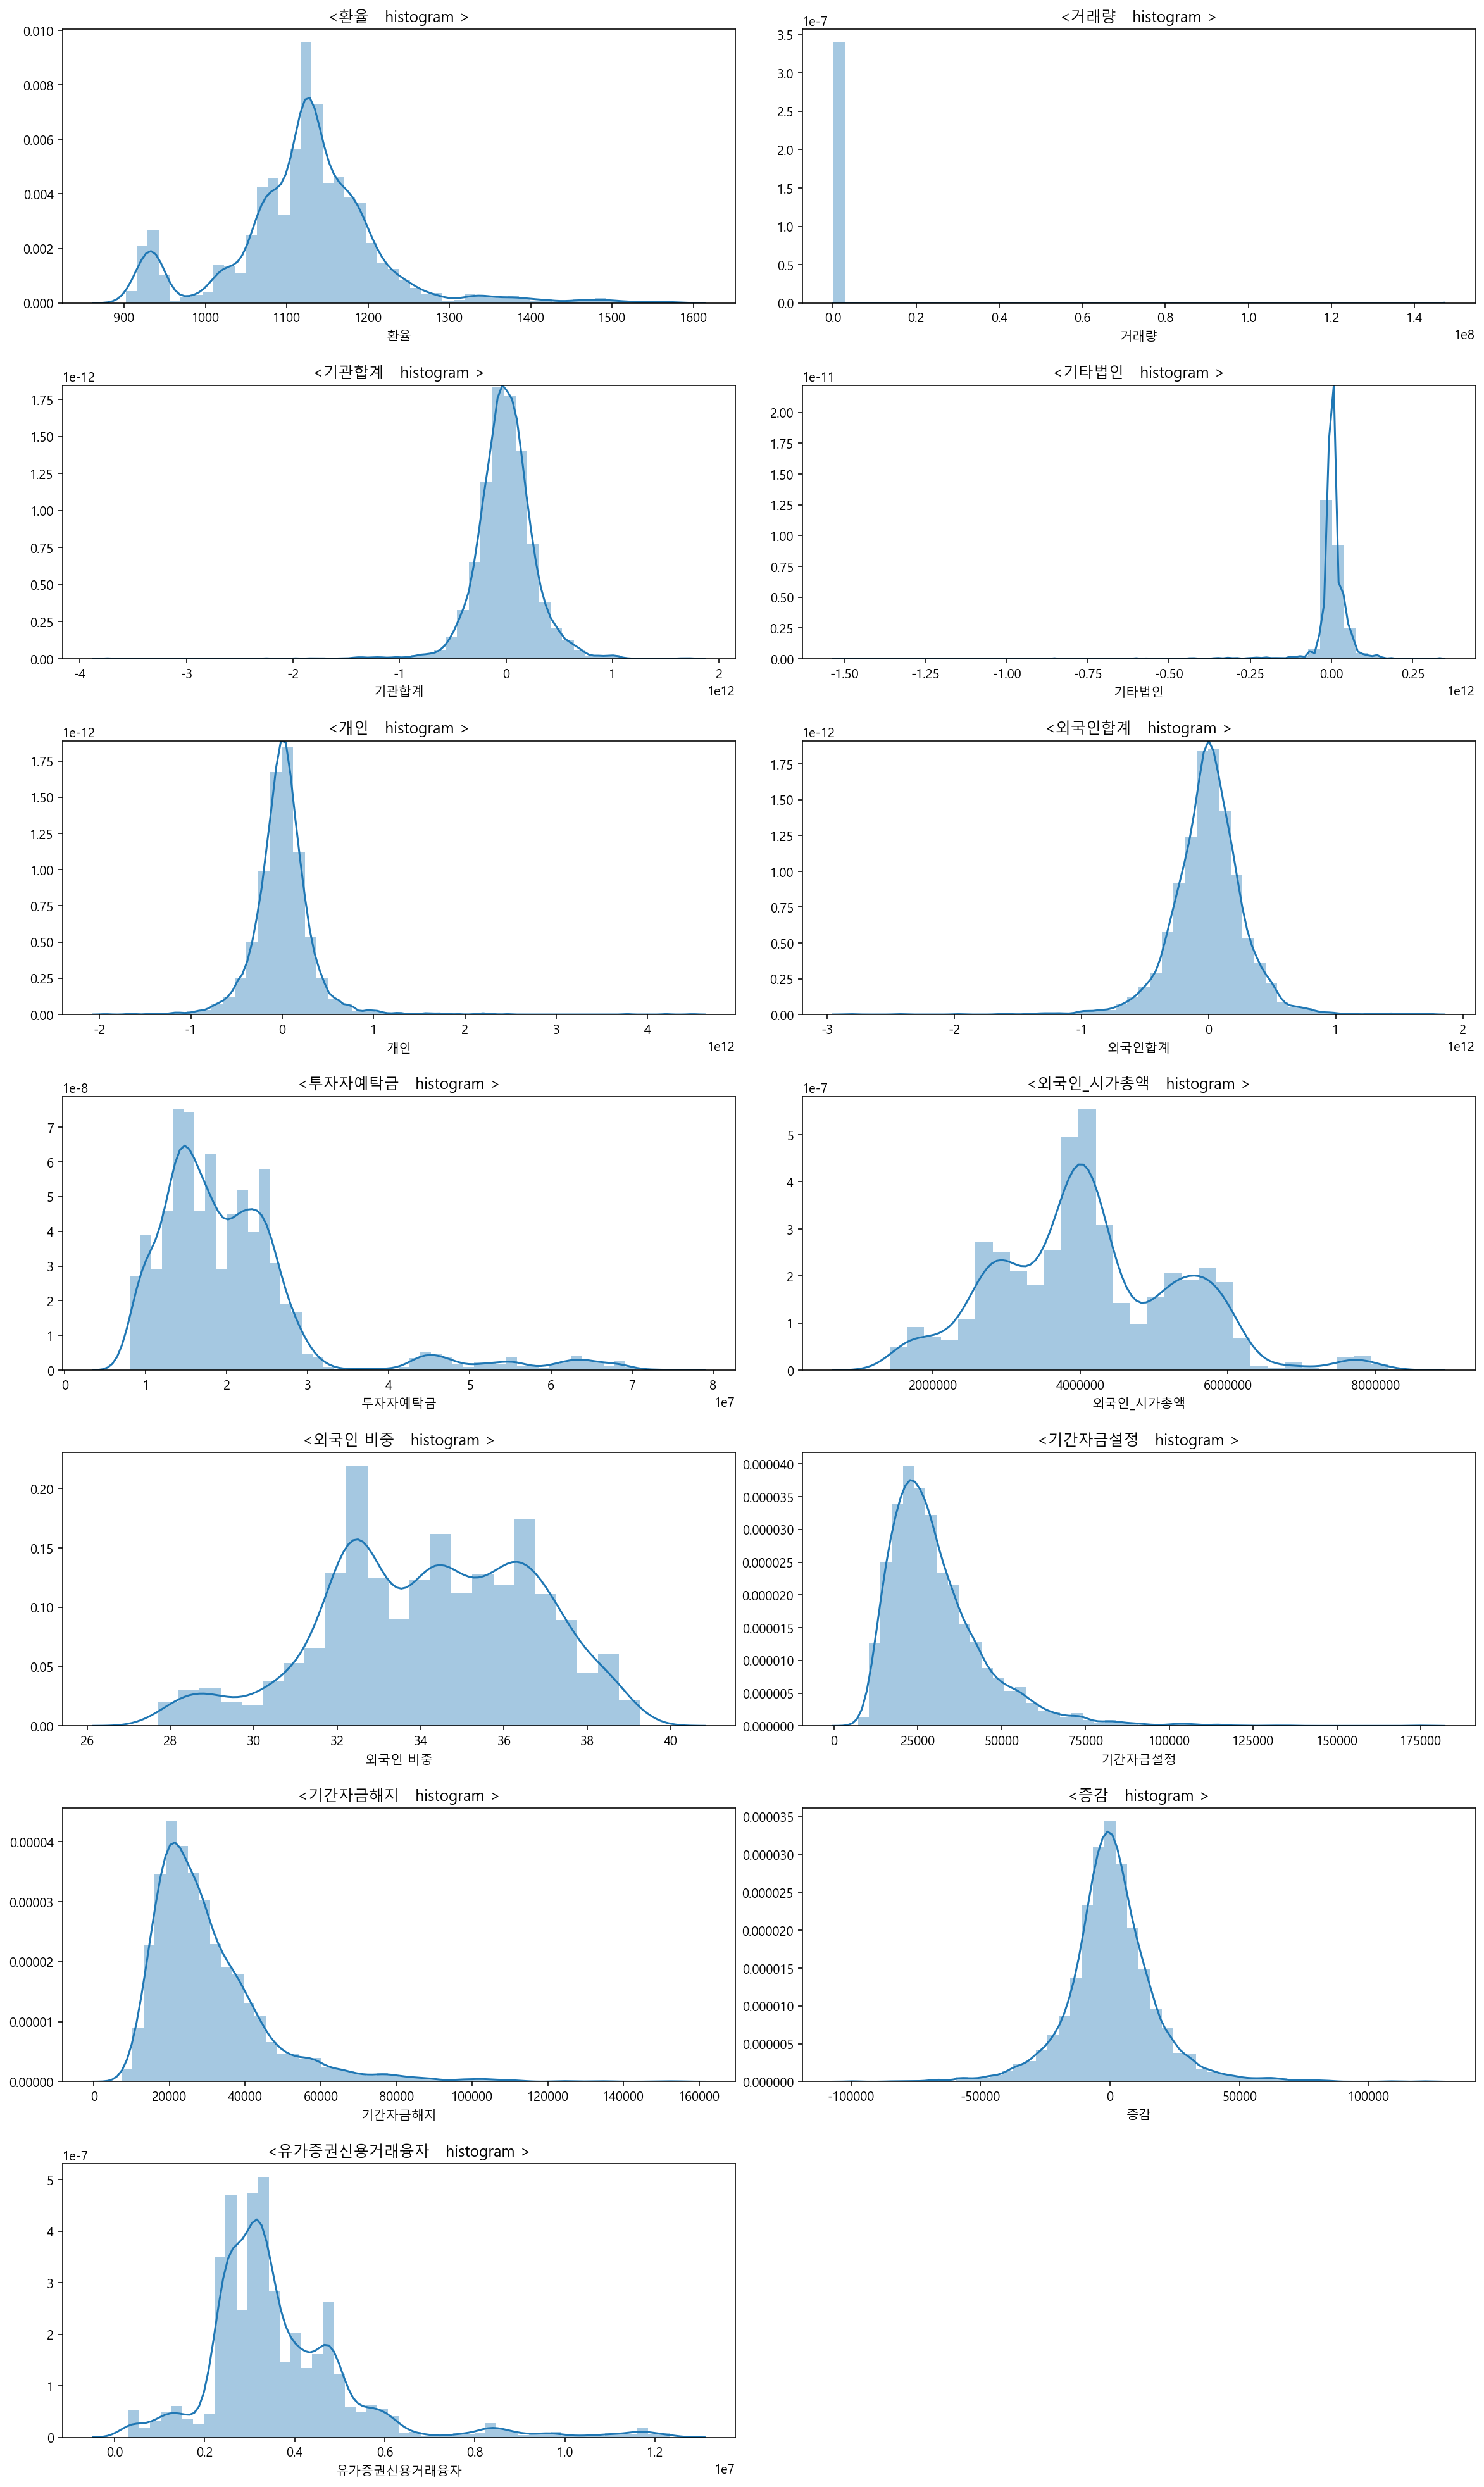

In [12]:
# 변수별 hist plot
final2 = final.drop(['date'], axis=1)

fig = plt.figure(figsize=(20,35))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for i, j in enumerate(final2.columns):
    fig.add_subplot(7,2,i+1)
    sns.distplot(final2[j])
    plt.title('<' +  j + '   histogram >')

전반적으로 정규성을 따르지는 않고 있는 모습이다.    
거래량은 scale이 너무 커서,,,plotting이 잘 안된다

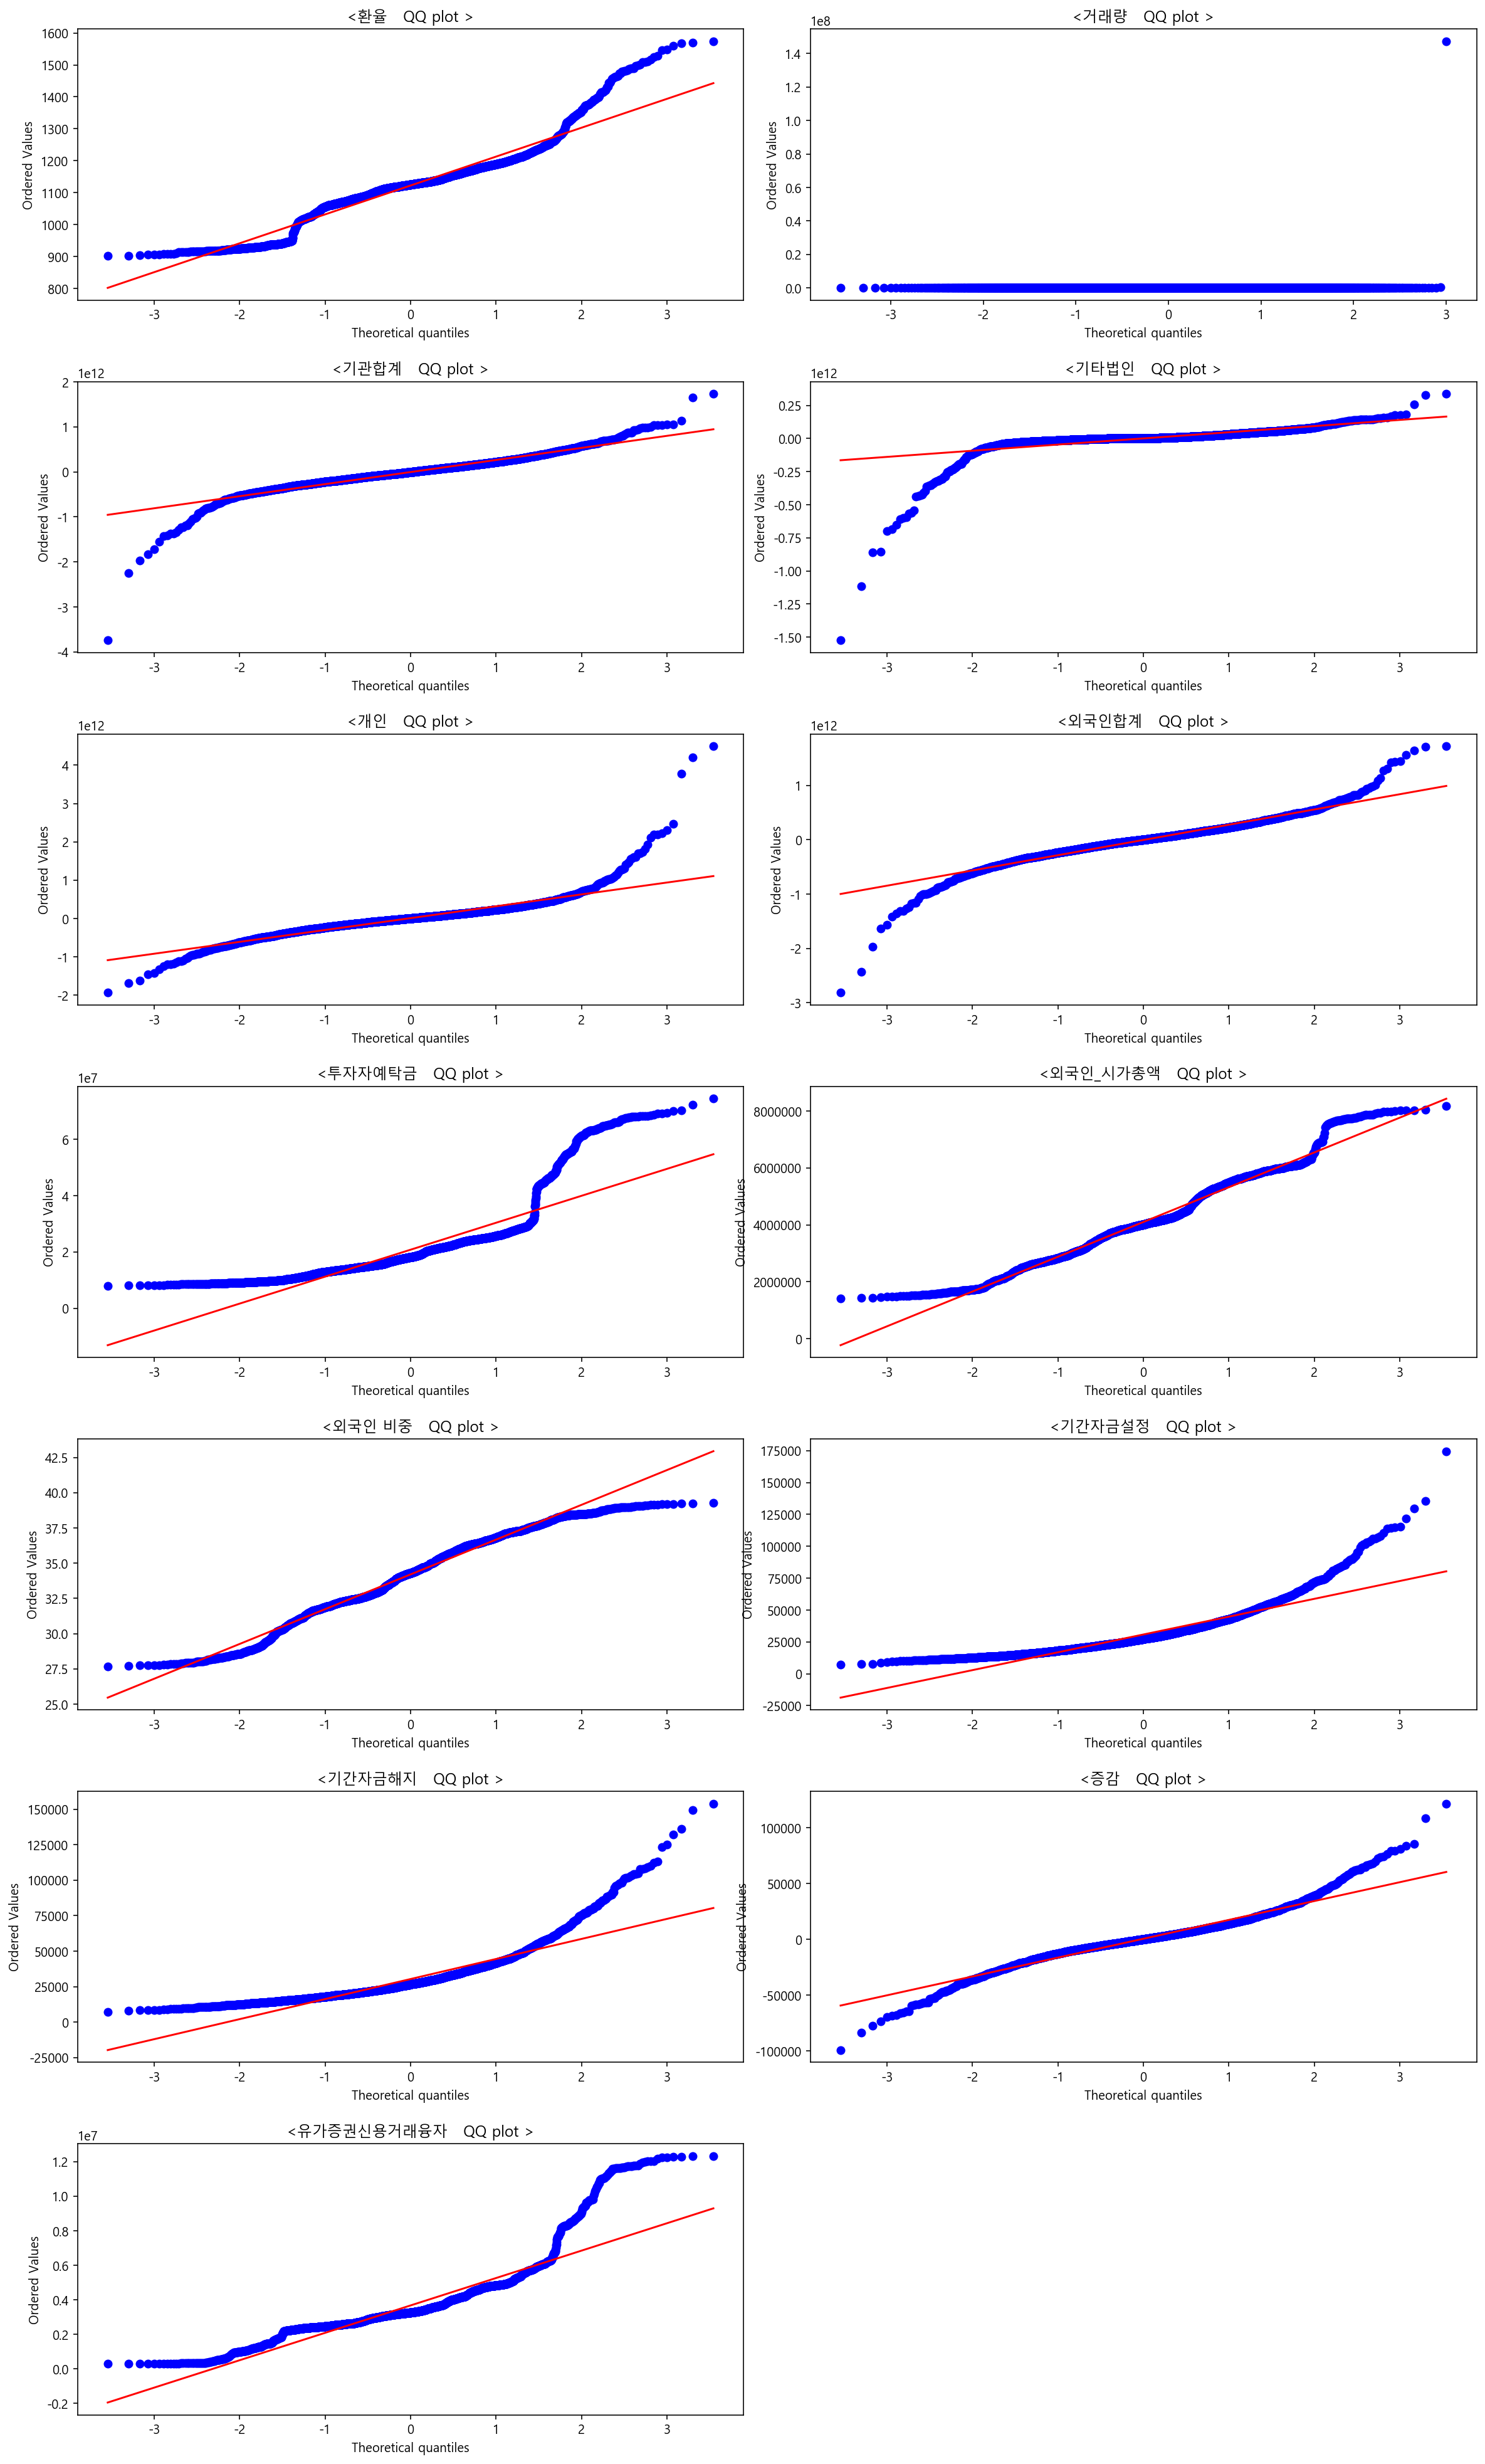

In [13]:
# 변수별 qq plot
fig = plt.figure(figsize=(20,35))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for i, j in enumerate(final2.columns):
    fig.add_subplot(7,2,i+1)
    stats.probplot(final2[j], plot=plt)
    plt.title('<' +  j + '   QQ plot >')

트리모델링을 할때는 정규성 가정이 불필요하므로, 이 점은 그냥 무시해도 될 듯 하다.

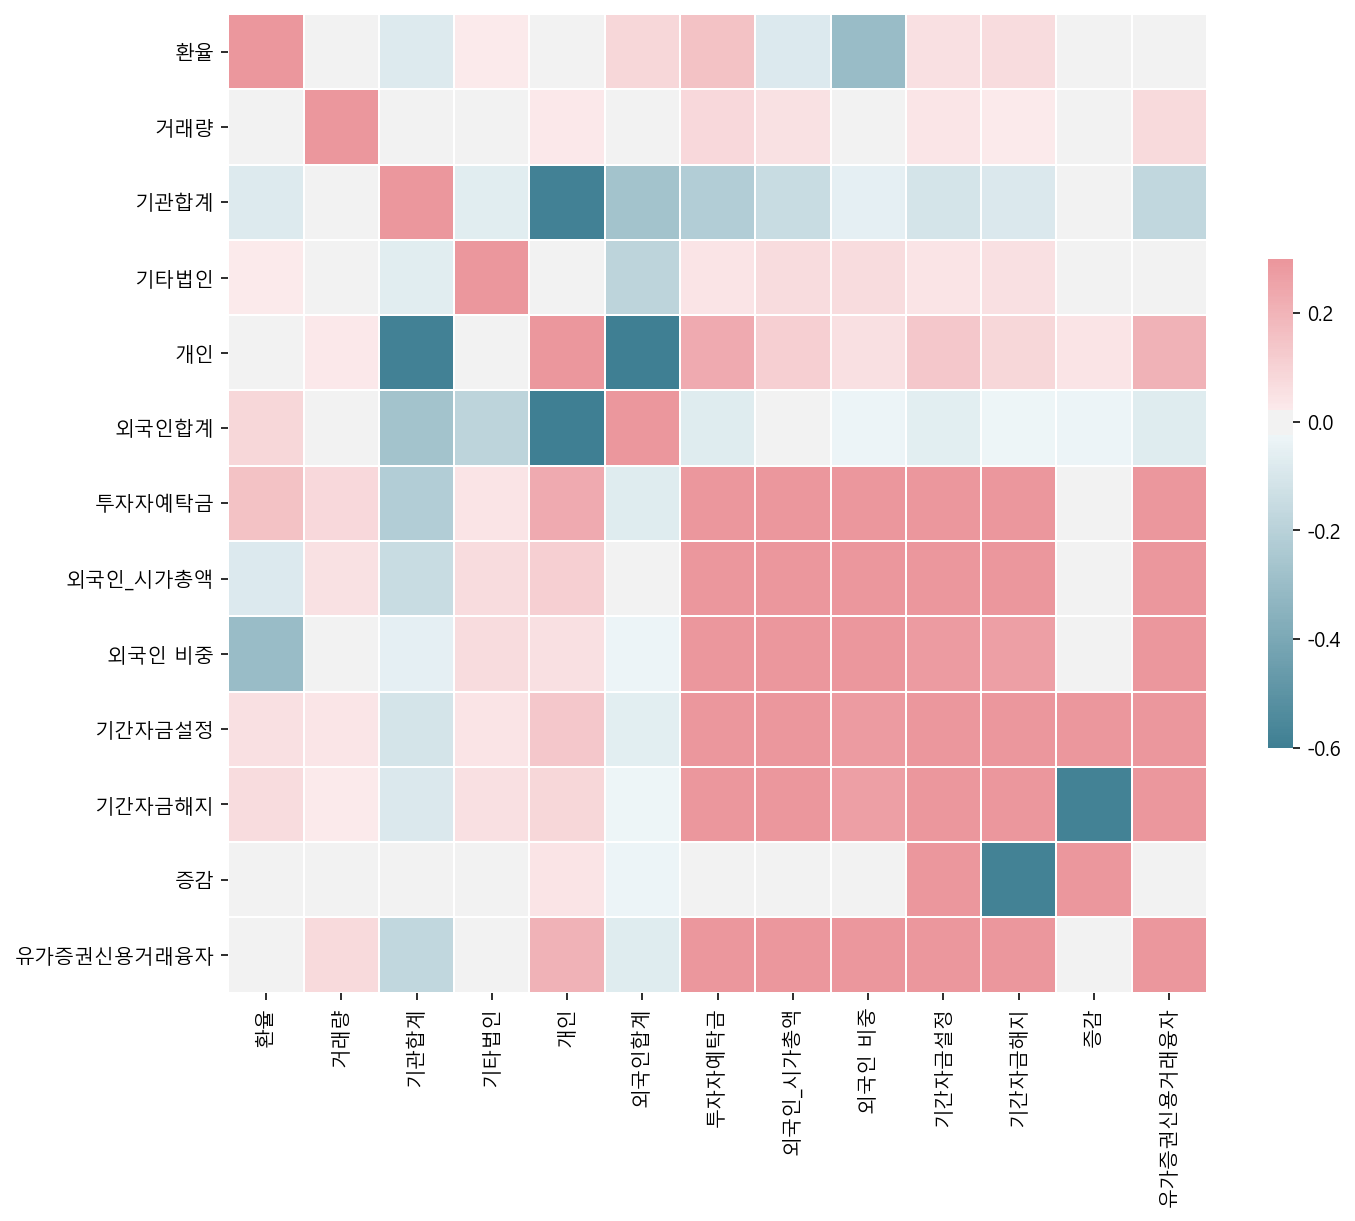

In [14]:
# 상관관계(선형관계 파악)
corr = final.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Labeling
- TOM 기간을 1으로, ROM 기간은 0으로 라벨링한다.
- 기준은 논문에 나와있는 기준을 이용

> TOM에 해당하는 날짜 : 매월 마지막 영업일과 첫 영업일 이틀

In [17]:
final.head()

,date,환율,거래량,기관합계,기타법인,개인,외국인합계,투자자예탁금,외국인_시가총액,외국인 비중,기간자금설정,기간자금해지,증감,유가증권신용거래융자
0,2007-01-02,929.6,14430.0,-49479494305,0,30058872445,19420621860,8561691.0,2631666,37.31,27941,41180,-13239,333970
1,2007-01-03,926.0,19080.0,-89720793350,0,145826577680,-56105784330,8918052.0,2579421,37.24,24504,25611,-1108,335226
2,2007-01-04,926.1,23660.0,-139354057235,0,230080115165,-90726057930,8942186.0,2553242,37.18,24670,25024,-354,336194
3,2007-01-05,931.2,27032.0,-184343344810,0,201882104850,-17538760040,8923076.0,2532473,37.18,17931,19785,-1853,329158
4,2007-01-08,932.6,17414.0,89929510150,0,141833422150,-231762932300,8870678.0,2506114,37.19,20819,18014,2805,327918


In [18]:
# 년, 월만 추출
final['year'] = final['date'].dt.year
final['month'] = final['date'].dt.month
# final['is_tom'] = 0

In [26]:
# 매월 첫 영업일 
a = pd.DataFrame(final.groupby(['year', 'month'])['date'].first())
a['is_tom'] = 1

# 매월 마지막 영업일 
b = pd.DataFrame(final.groupby(['year', 'month'])['date'].last())
b['is_tom'] = 1

tom_data = pd.concat([a, b])

data = pd.merge(final, tom_data, how='outer').fillna(0)  # 나머지는 다 0으로 채운 라벨링 데이터
data['is_tom'] = data['is_tom'].astype(int)

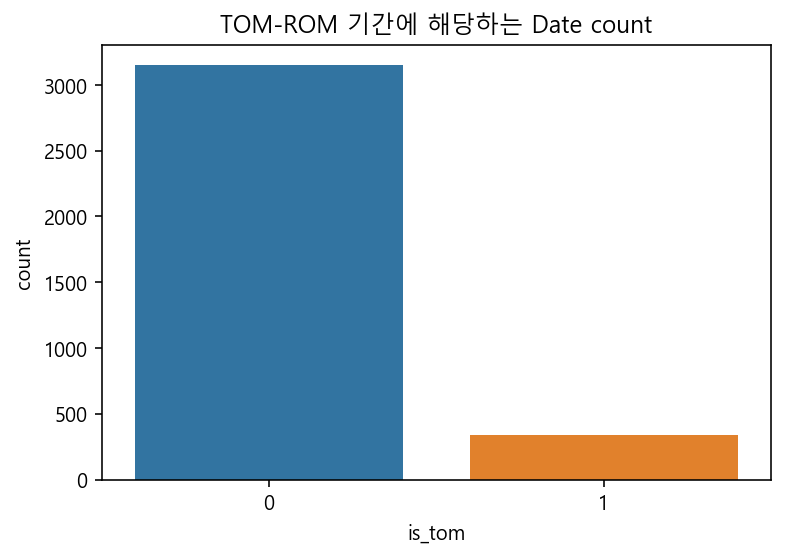

In [42]:
sns.countplot(data['is_tom'])
plt.title('TOM-ROM 기간에 해당하는 Date count')
plt.show()

In [38]:
data['is_tom'].value_counts()

0    3148
1     342
Name: is_tom, dtype: int64

2007년부터 2021년(현재 : 21.3.31 기준)까지 tom기간에 해당하는 데이터는 342개, rom기간은 3148개로 매우 unbalanced한 수치

In [45]:
data.head()

,date,환율,거래량,기관합계,기타법인,개인,외국인합계,투자자예탁금,외국인_시가총액,외국인 비중,기간자금설정,기간자금해지,증감,유가증권신용거래융자,year,month,is_tom
0,2007-01-02,929.6,14430.0,-49479494305,0,30058872445,19420621860,8561691.0,2631666,37.31,27941,41180,-13239,333970,2007,1,1
1,2007-01-03,926.0,19080.0,-89720793350,0,145826577680,-56105784330,8918052.0,2579421,37.24,24504,25611,-1108,335226,2007,1,0
2,2007-01-04,926.1,23660.0,-139354057235,0,230080115165,-90726057930,8942186.0,2553242,37.18,24670,25024,-354,336194,2007,1,0
3,2007-01-05,931.2,27032.0,-184343344810,0,201882104850,-17538760040,8923076.0,2532473,37.18,17931,19785,-1853,329158,2007,1,0
4,2007-01-08,932.6,17414.0,89929510150,0,141833422150,-231762932300,8870678.0,2506114,37.19,20819,18014,2805,327918,2007,1,0


In [47]:
data.columns

Index(['date', '환율', '거래량', '기관합계', '기타법인', '개인', '외국인합계', '투자자예탁금',
       '외국인_시가총액', '외국인 비중', '기간자금설정', '기간자금해지', '증감', '유가증권신용거래융자', 'year',
       'month', 'is_tom'],
      dtype='object')

<Figure size 792x360 with 0 Axes>

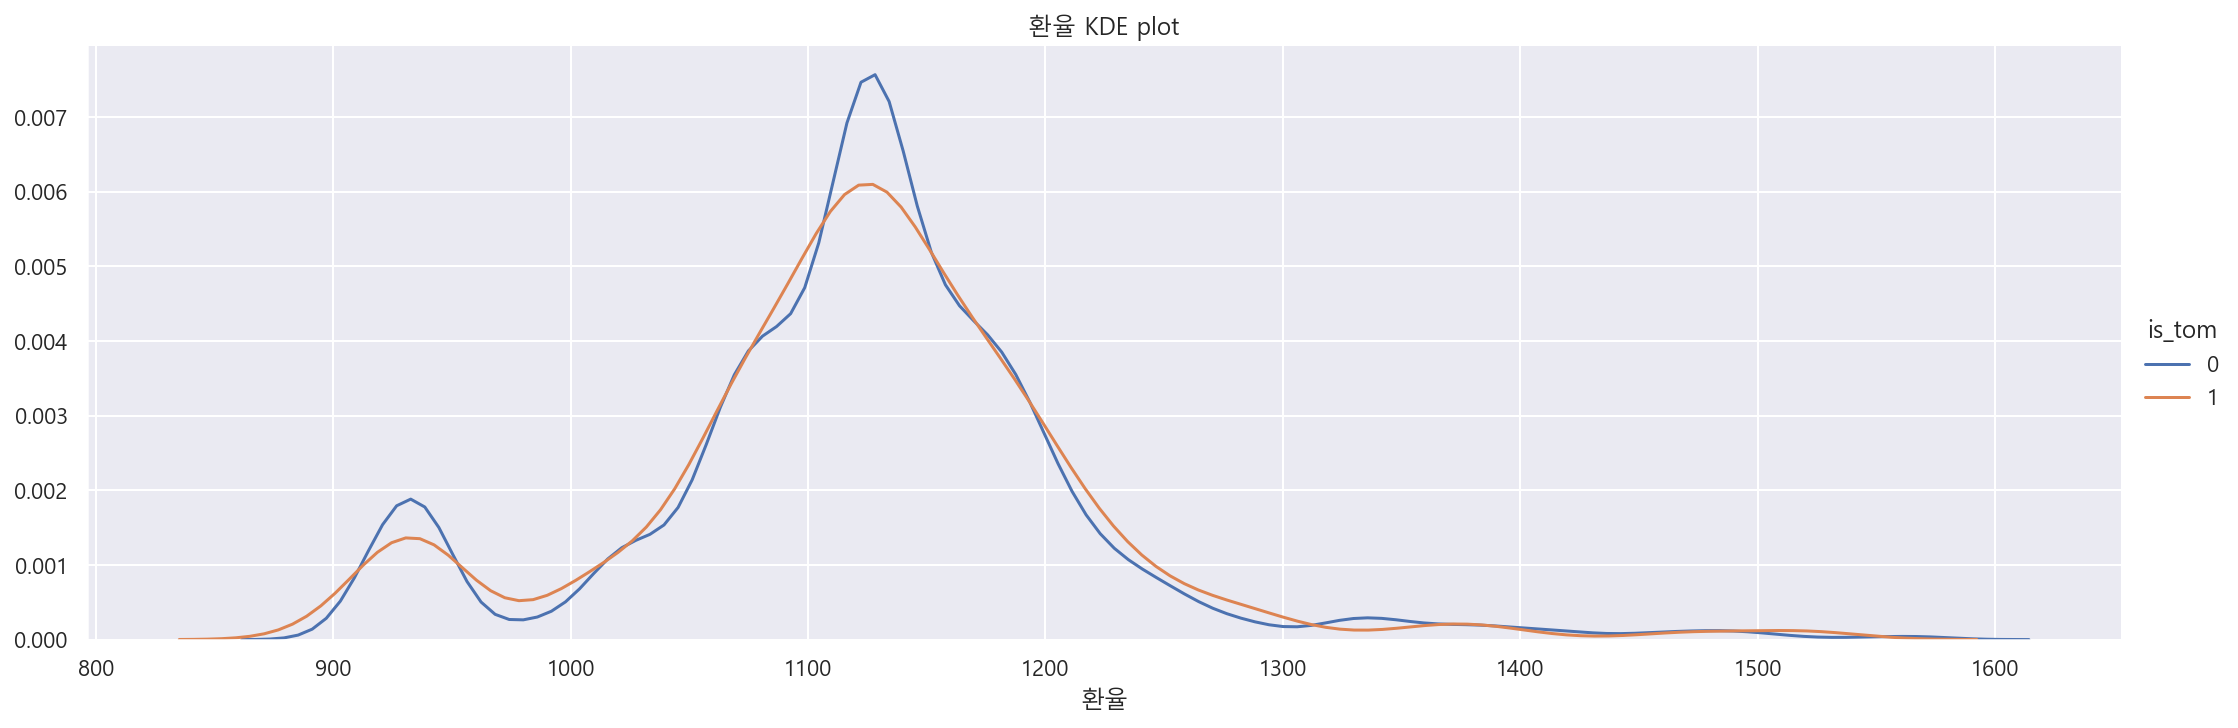

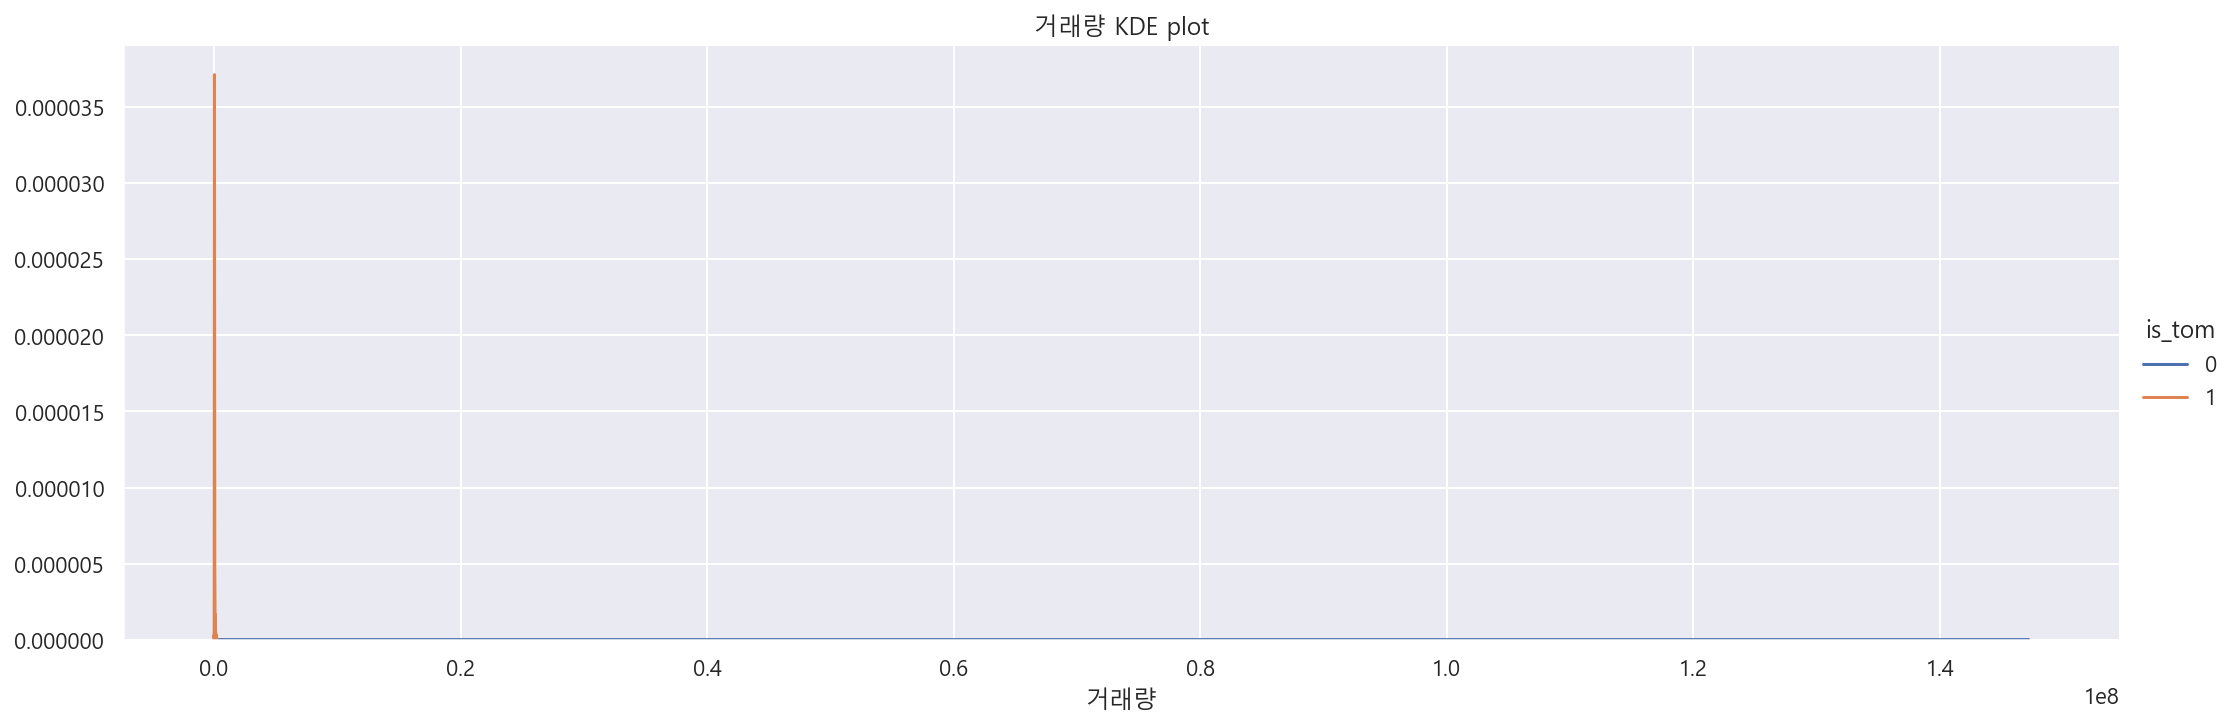

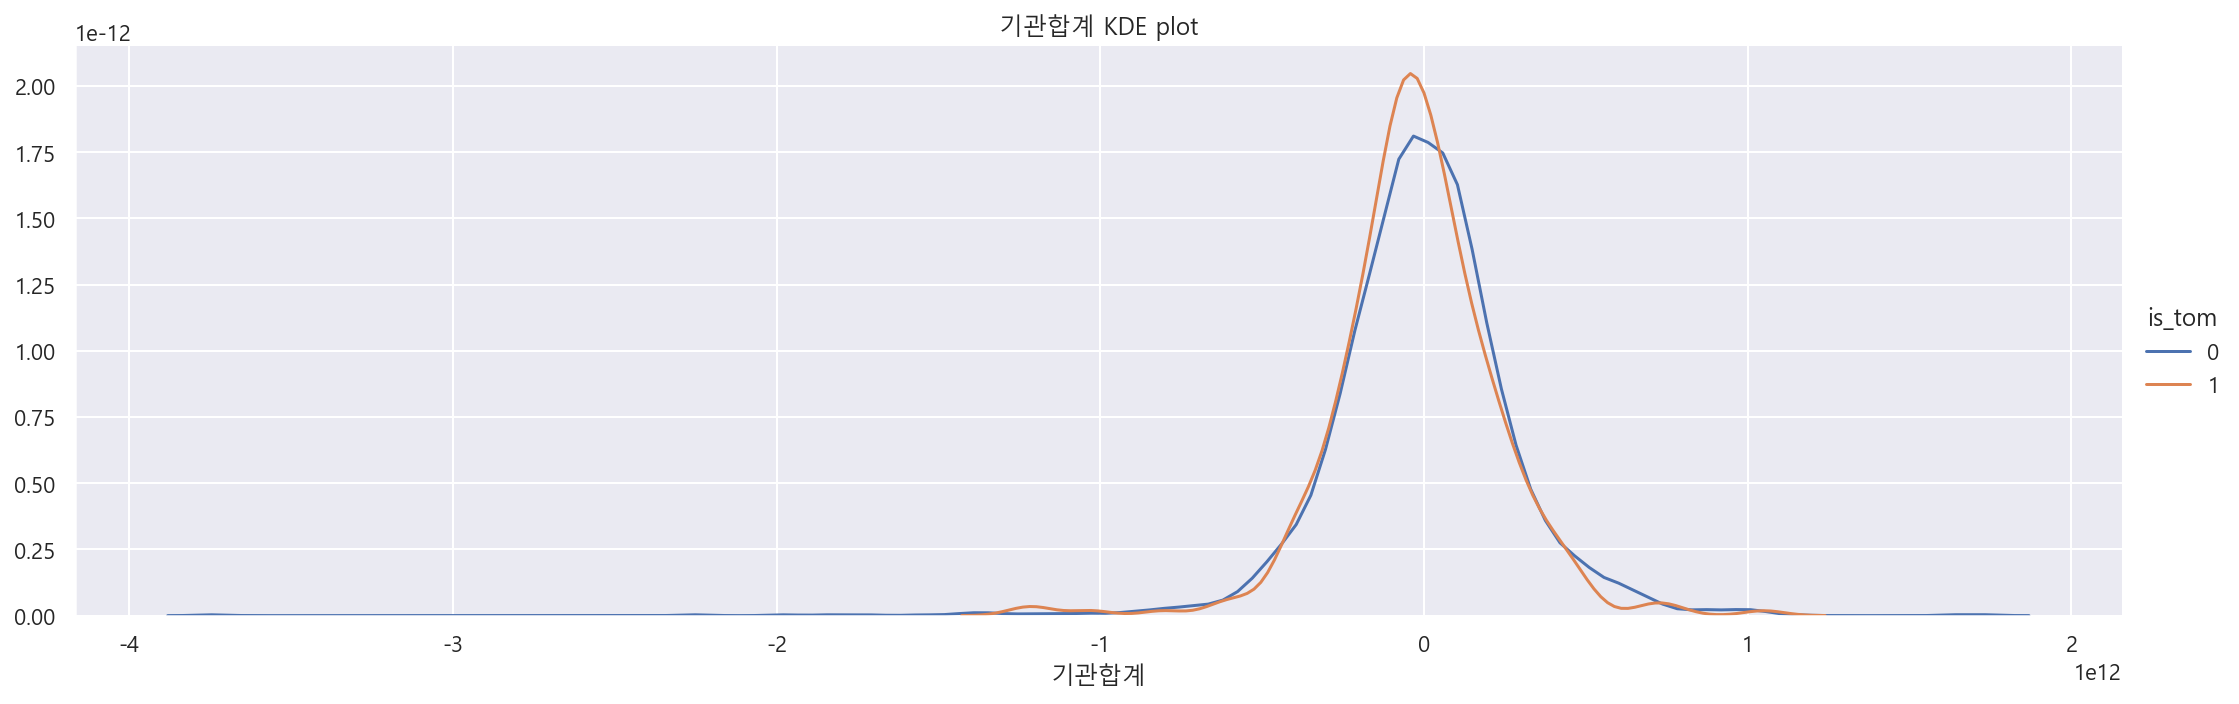

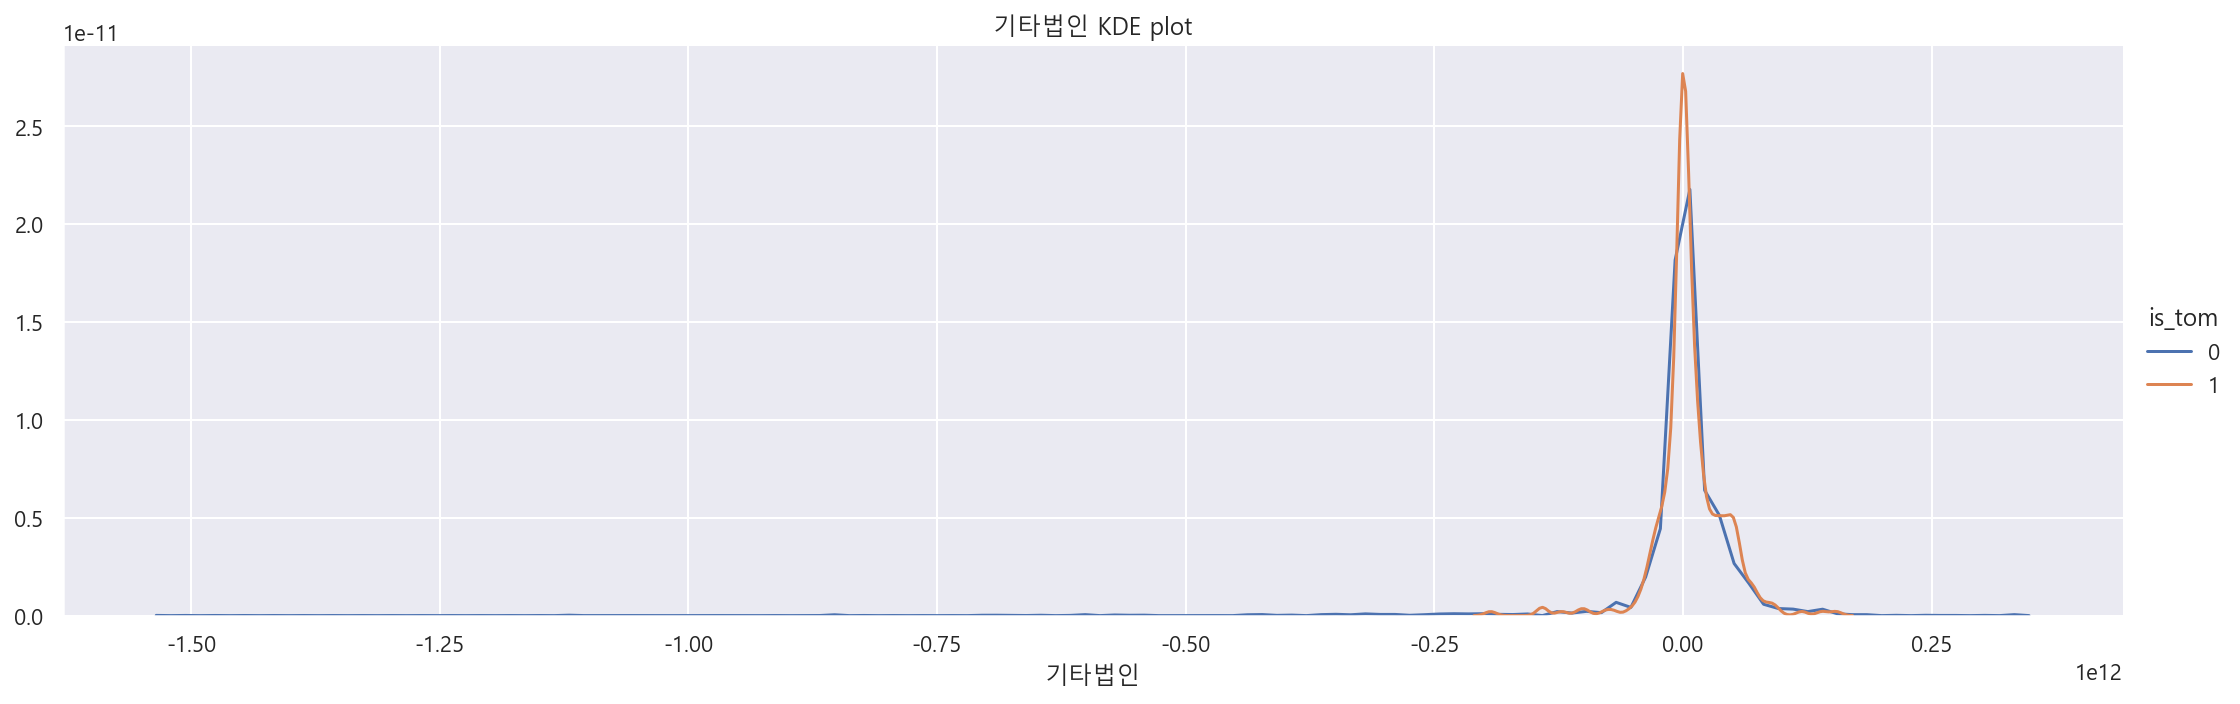

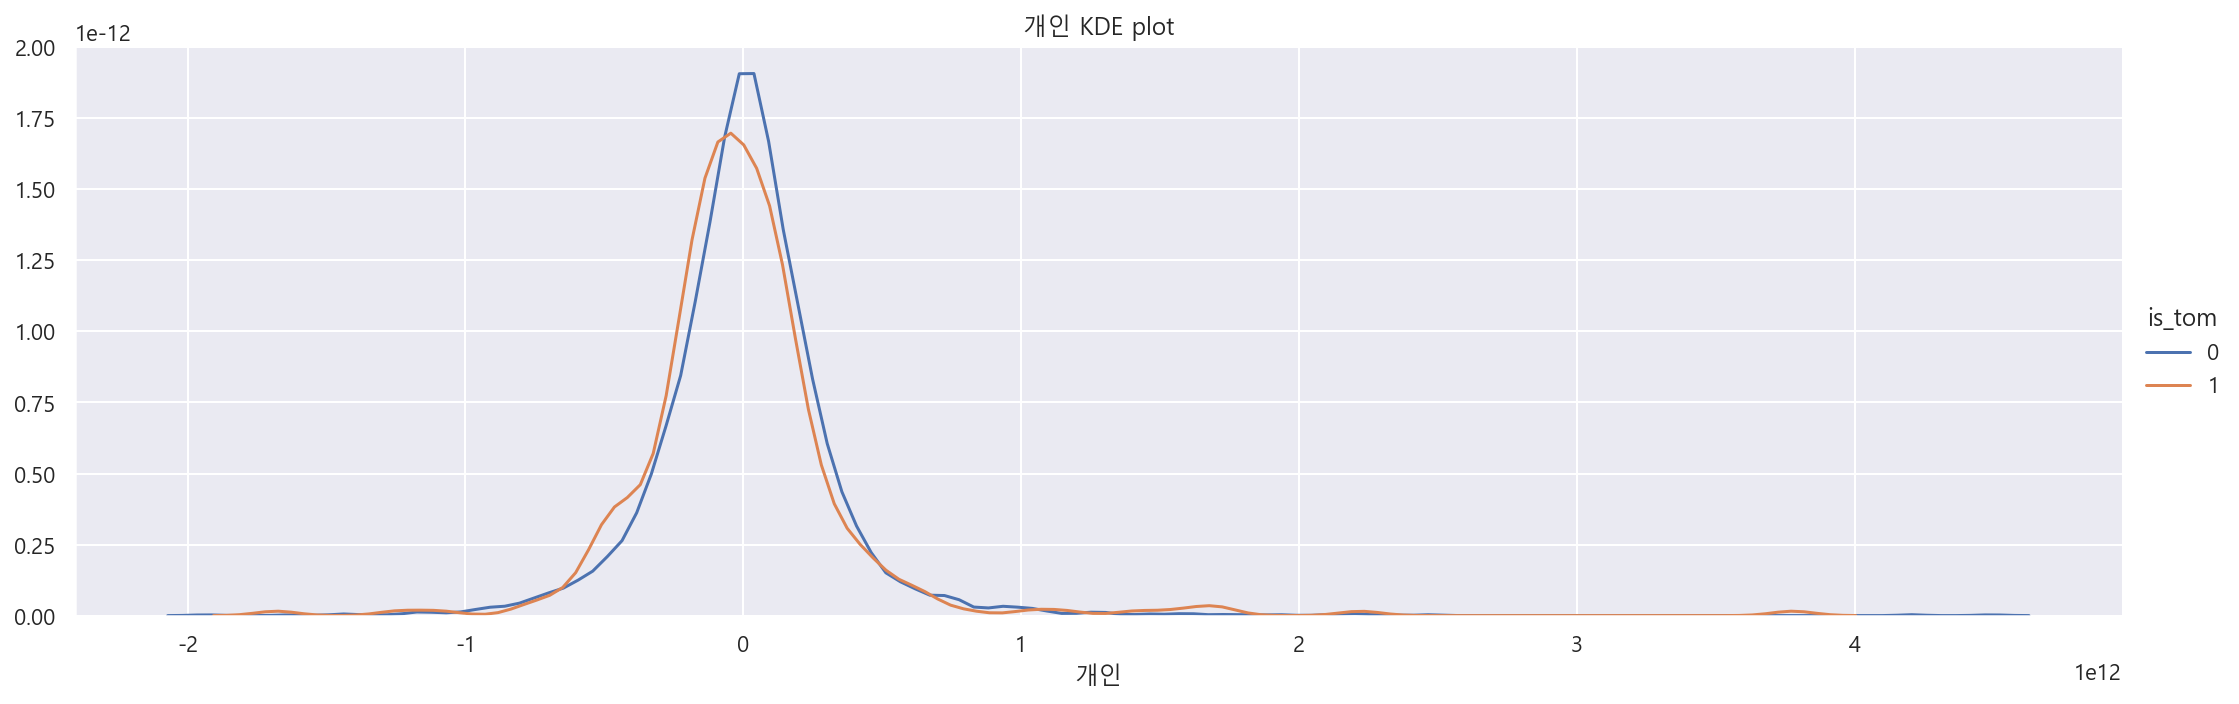

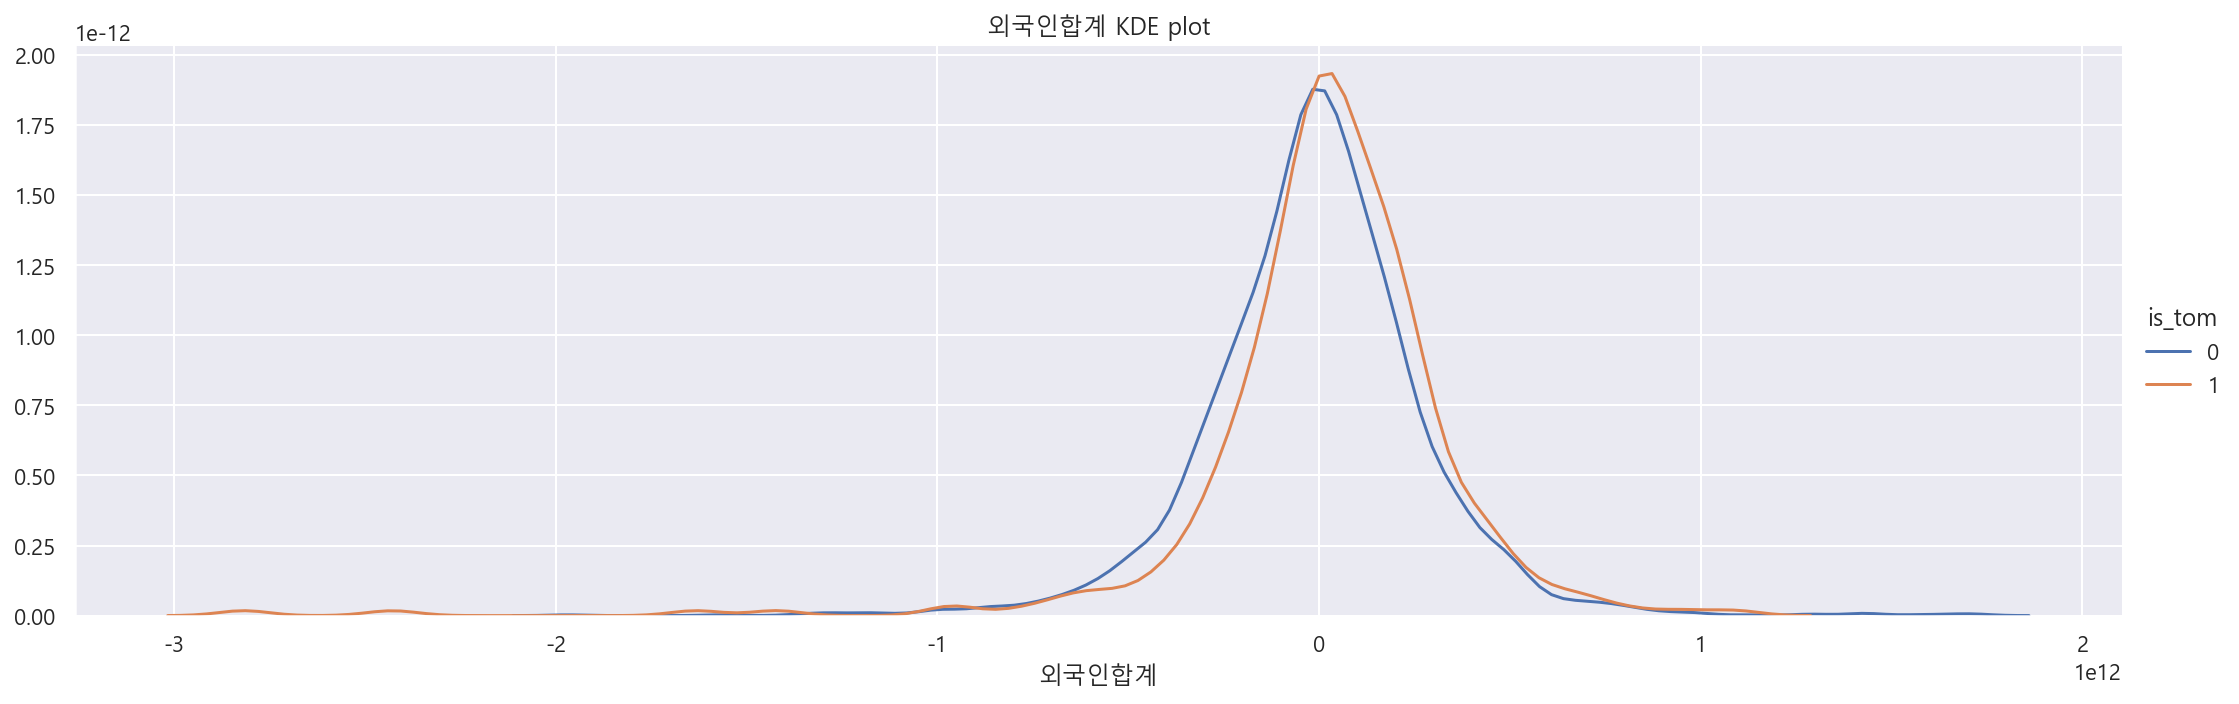

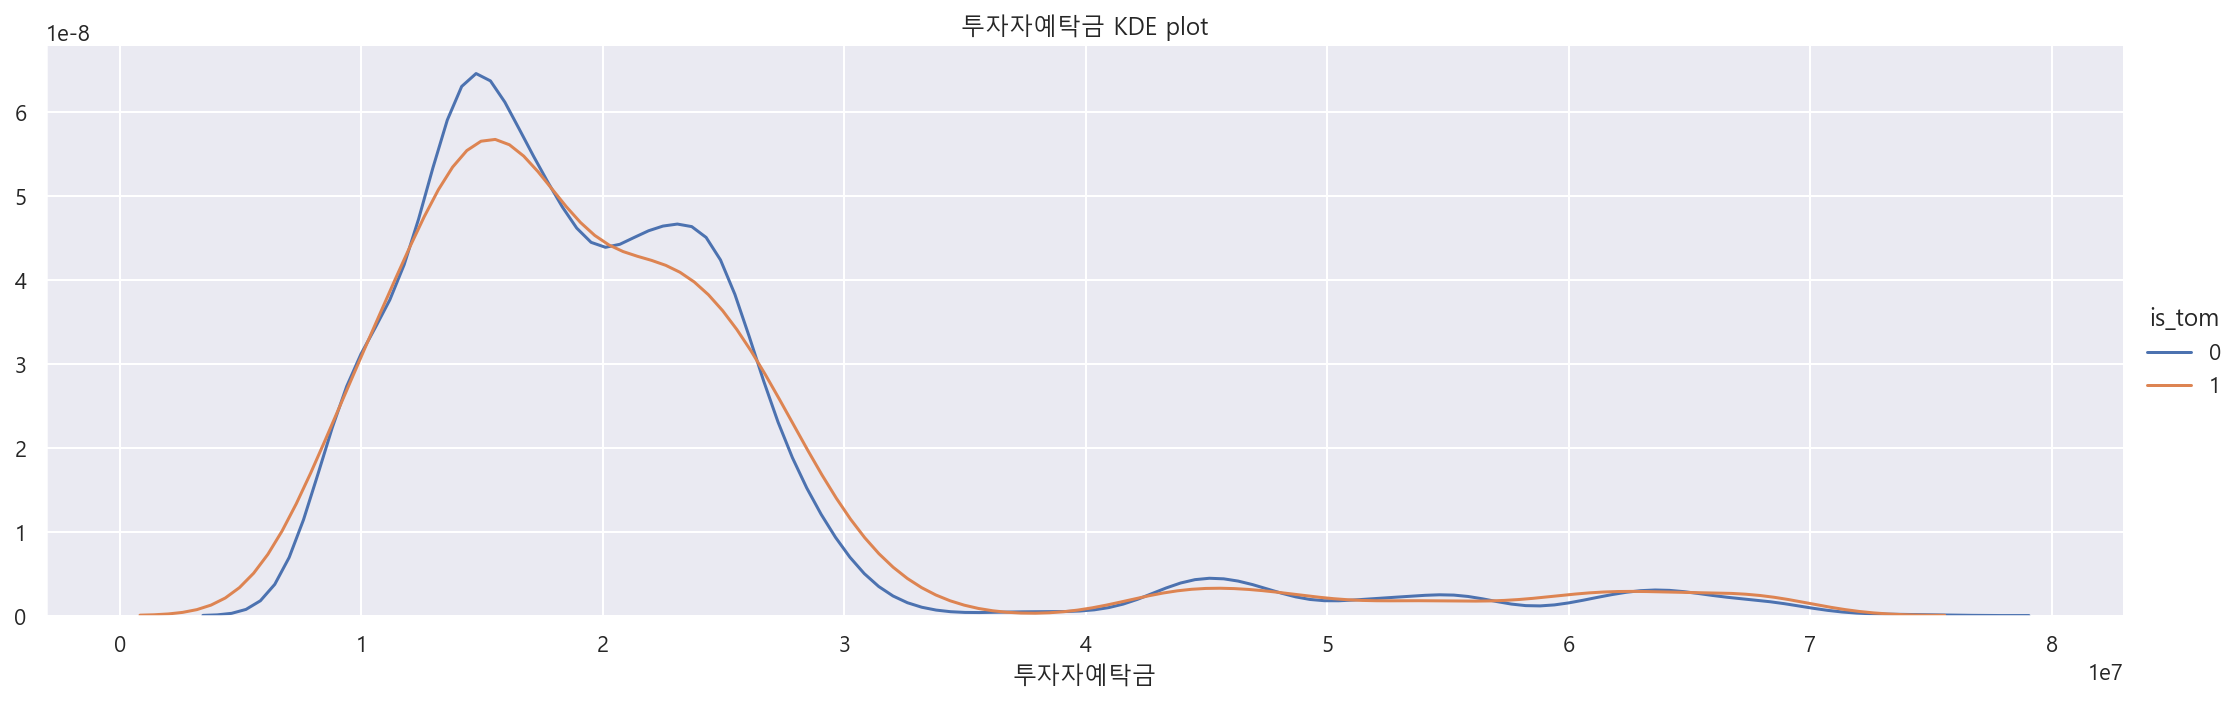

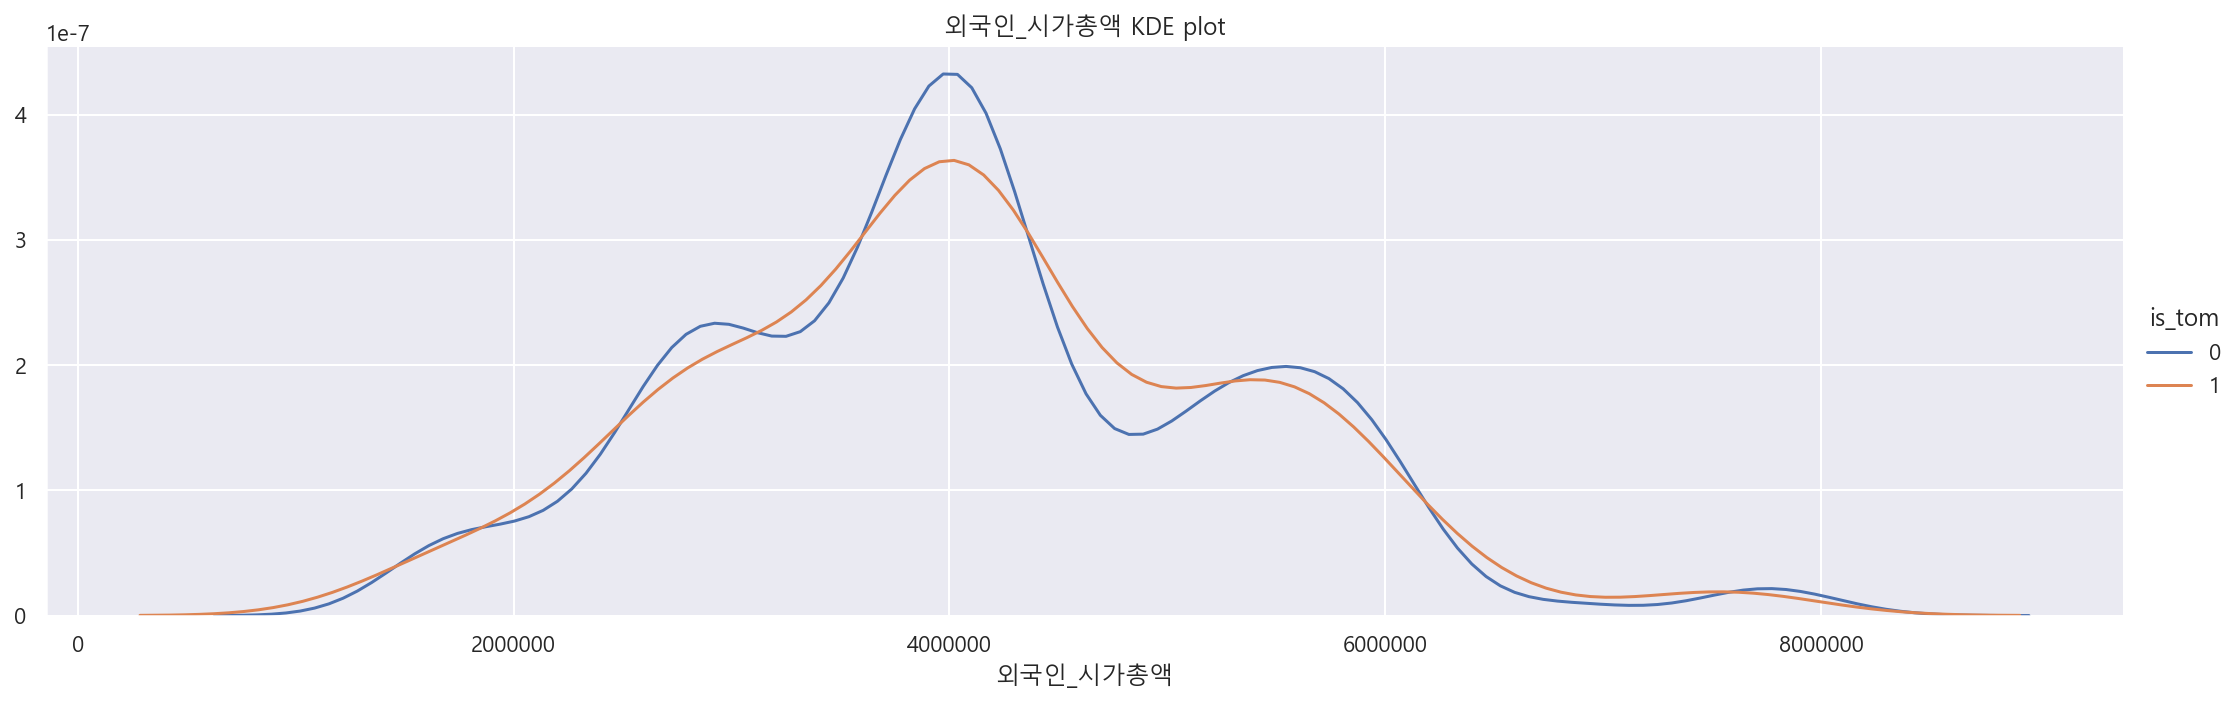

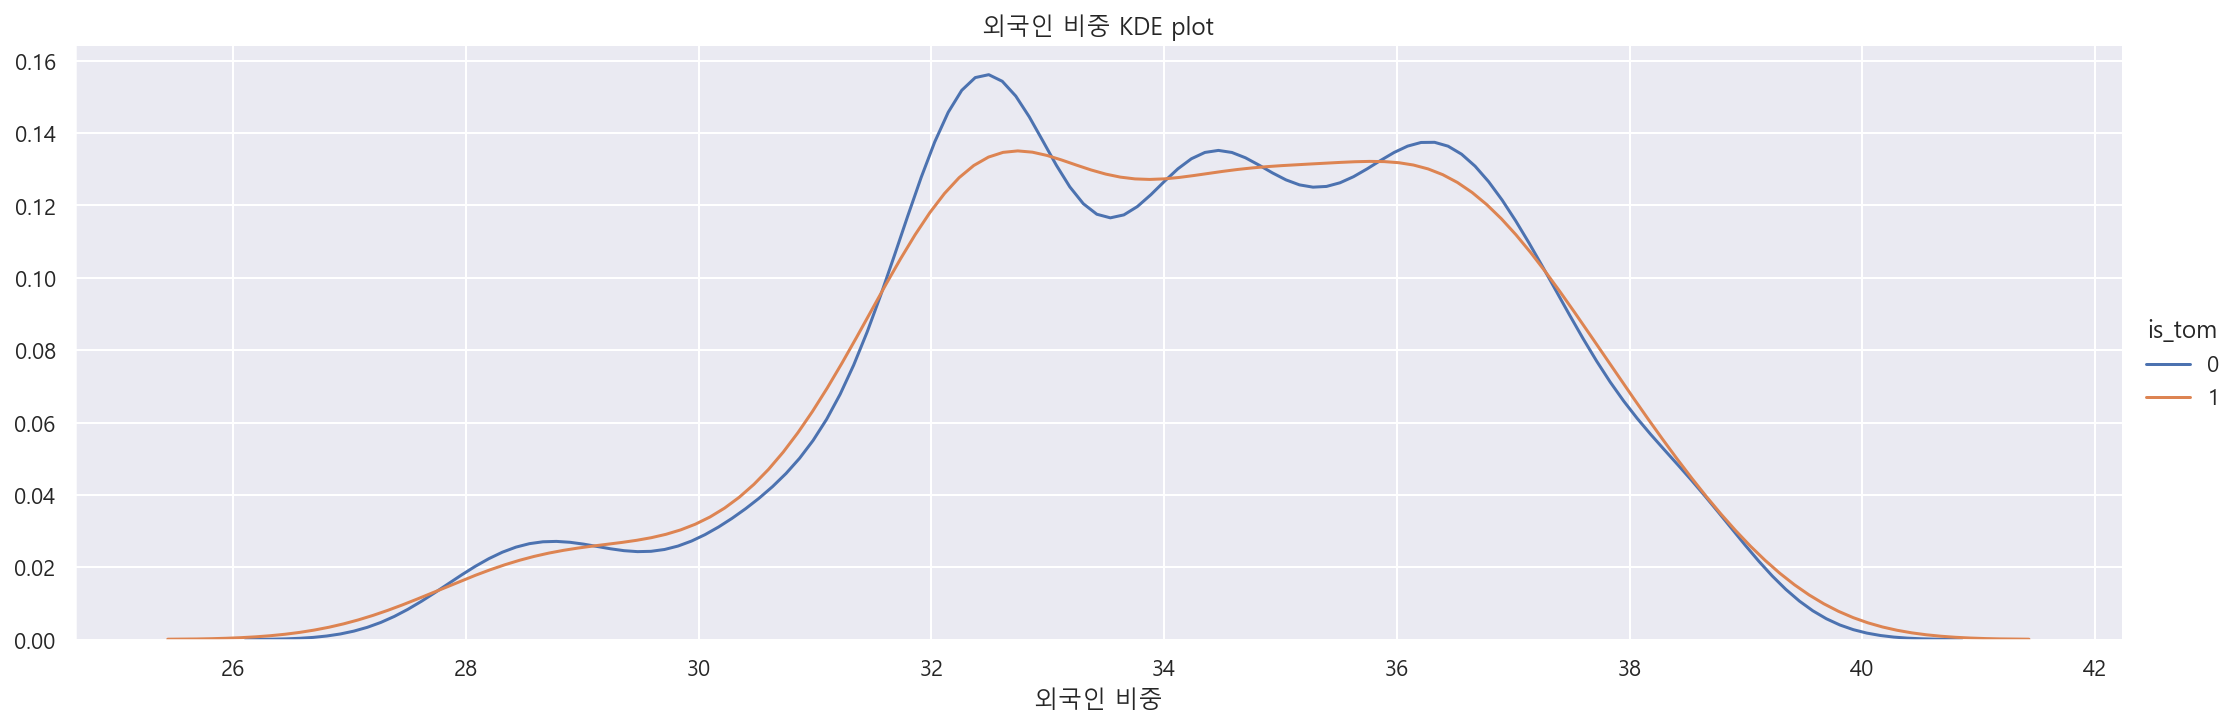

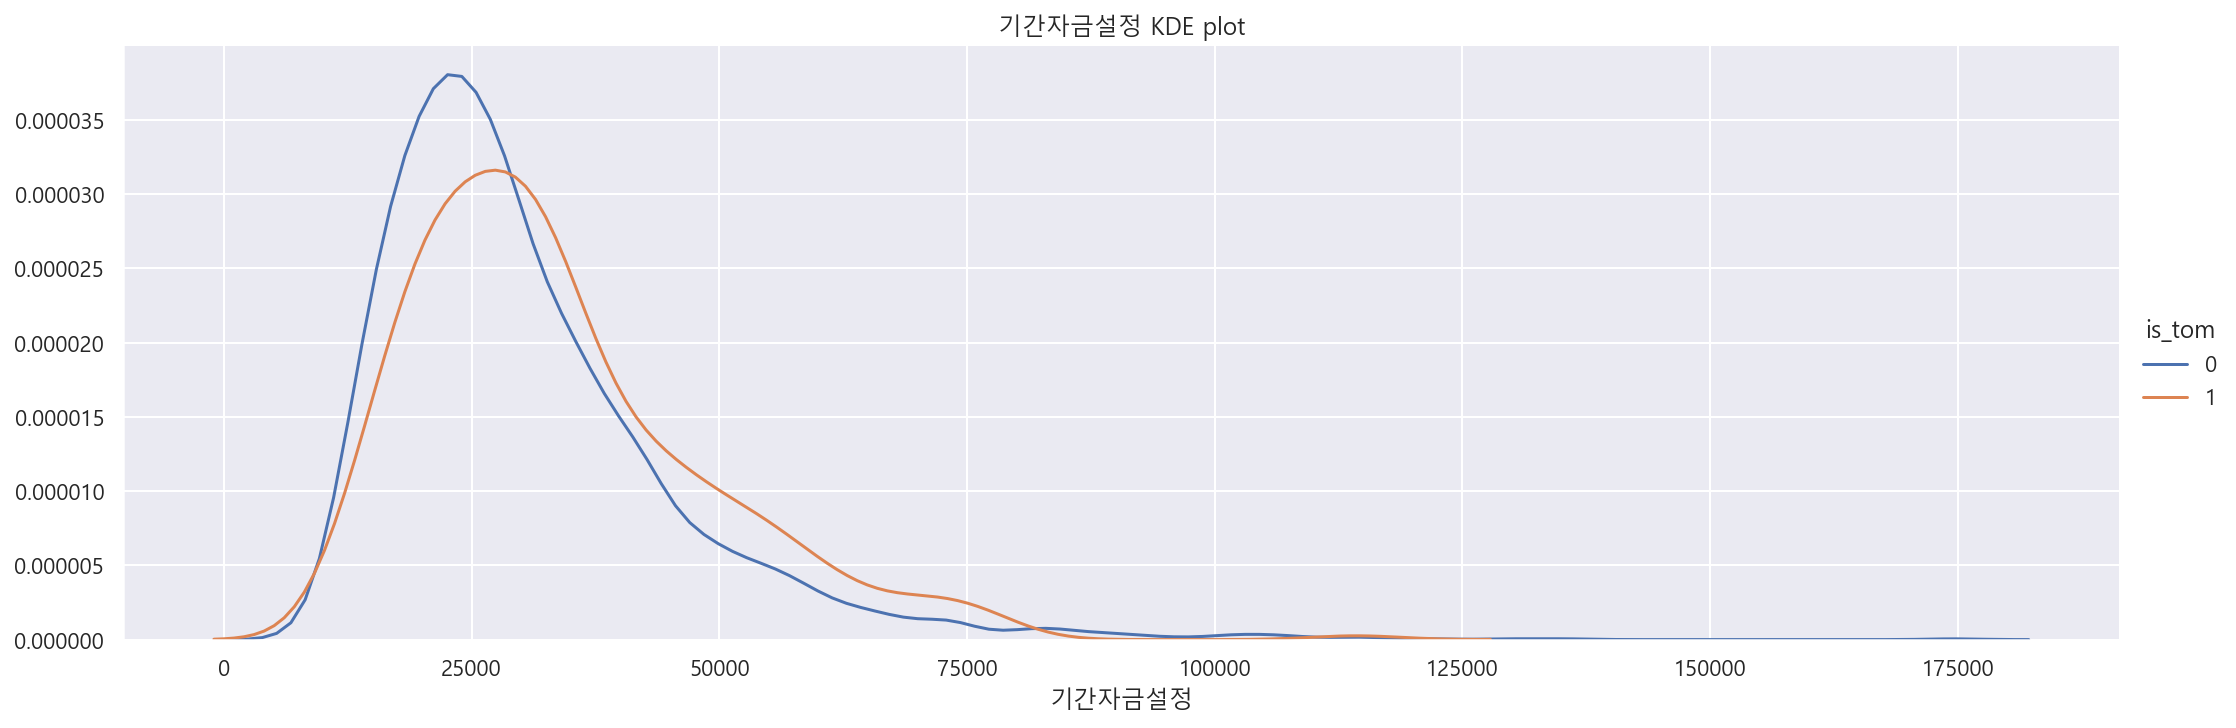

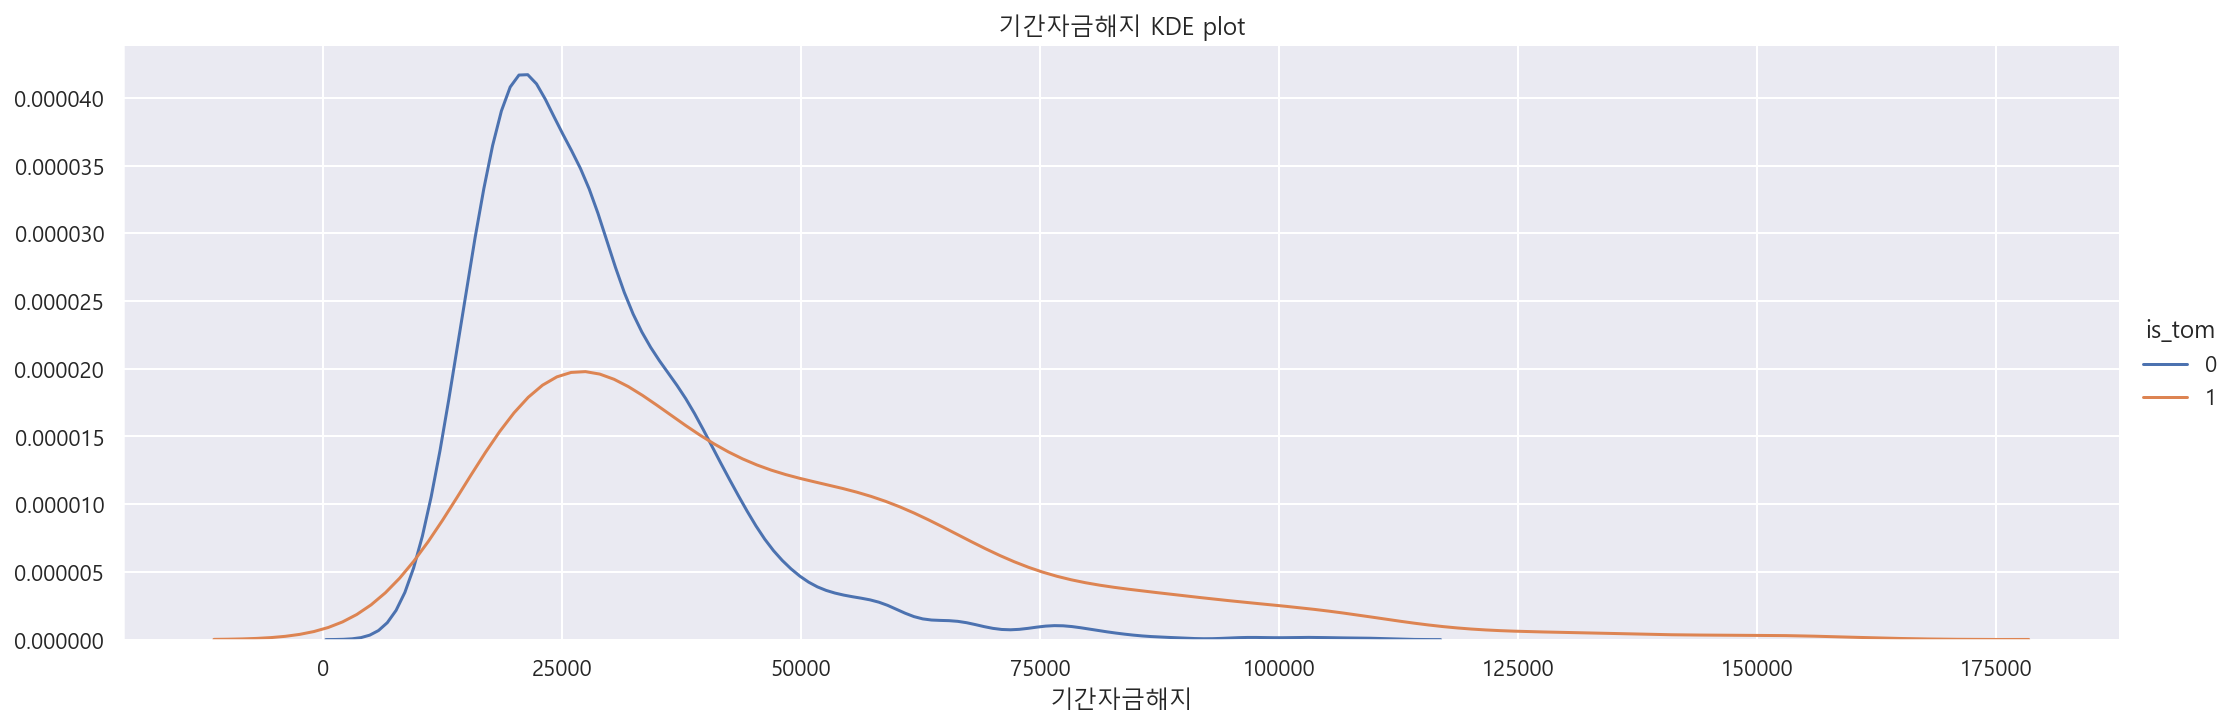

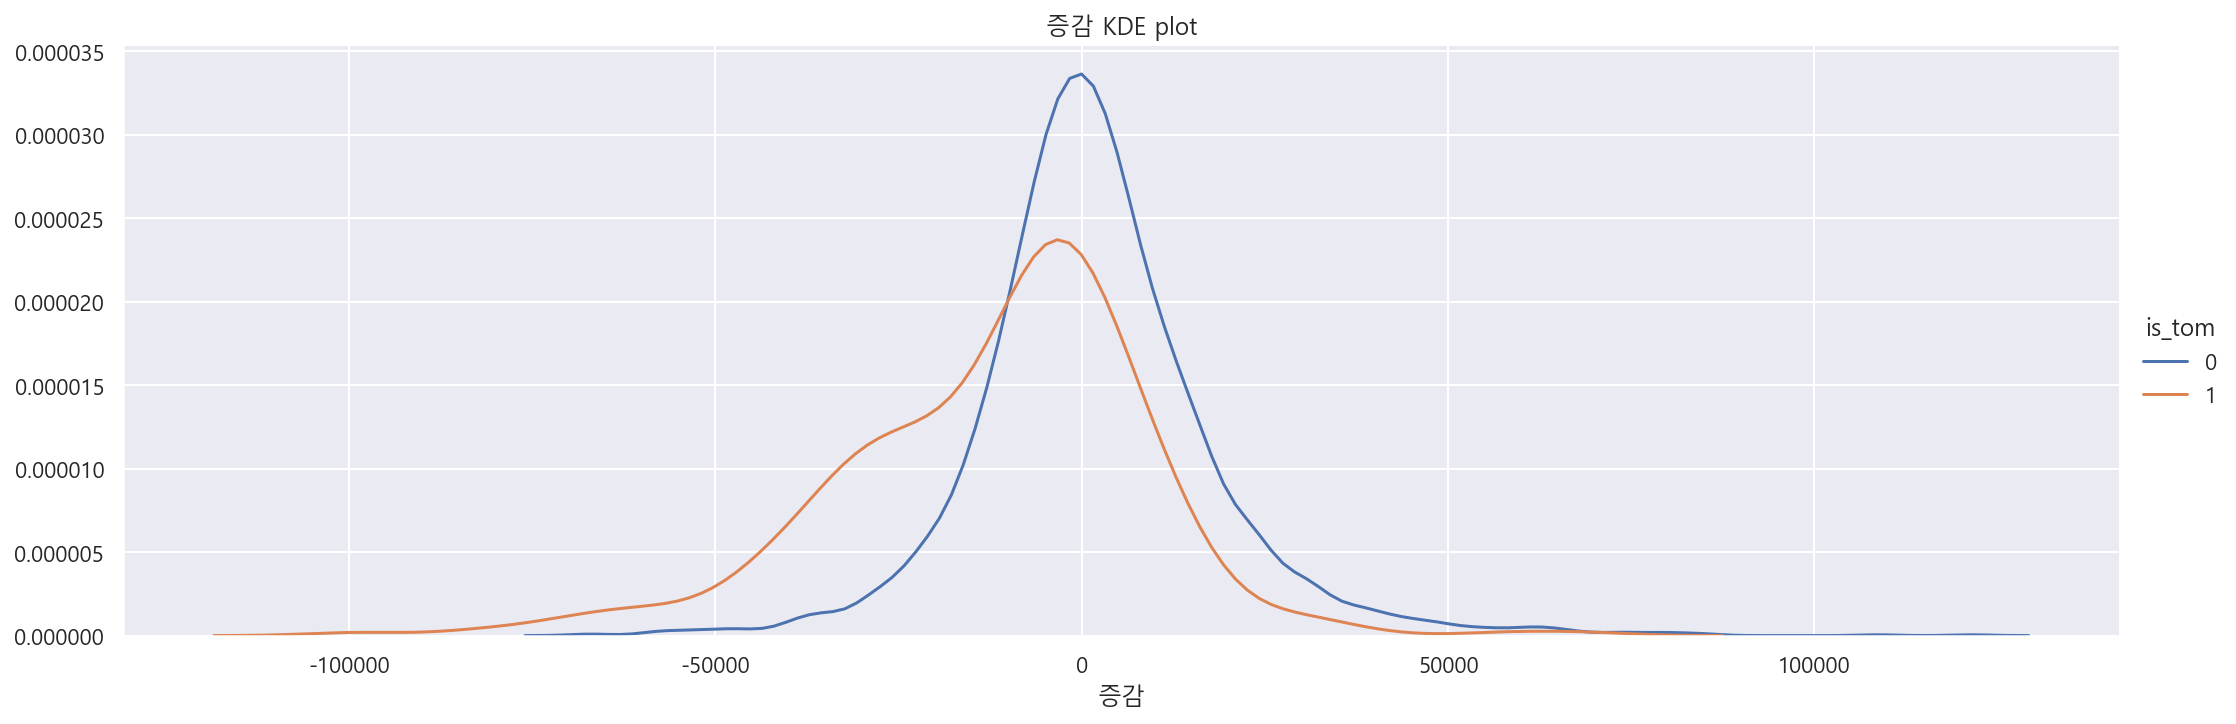

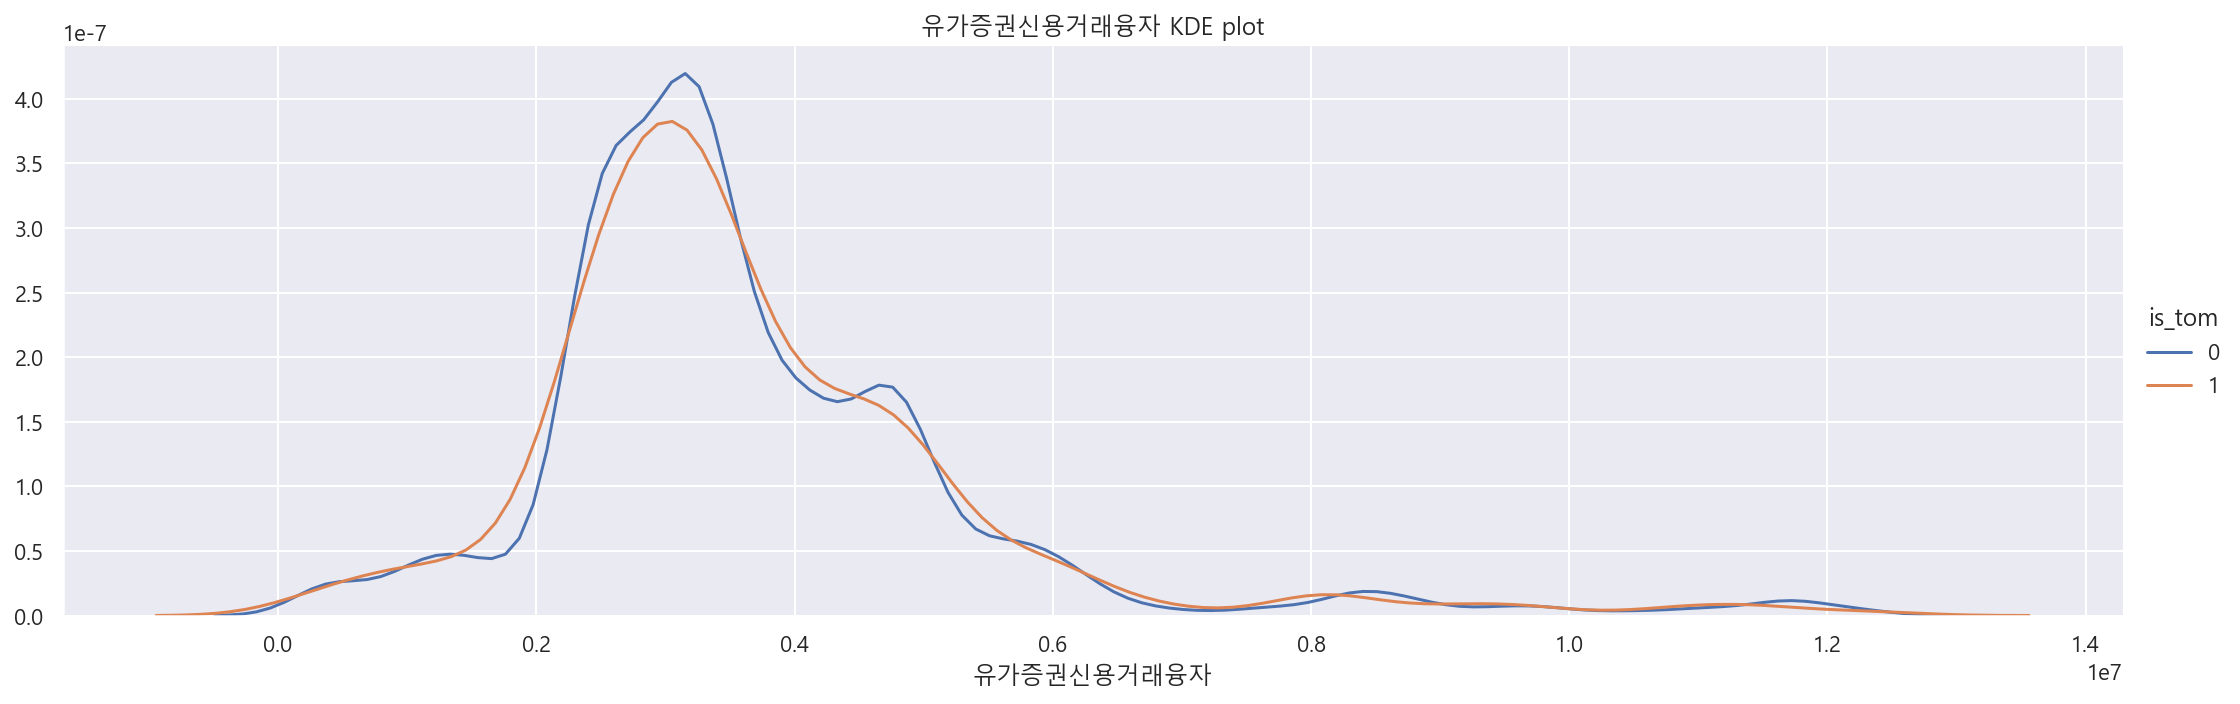

In [53]:
# tom-rom에 따른 확률밀도함수 분포 비교
hos_price_col = ['환율', '거래량', '기관합계', '기타법인', '개인', '외국인합계', '투자자예탁금',
       '외국인_시가총액', '외국인 비중', '기간자금설정', '기간자금해지', '증감', '유가증권신용거래융자', 'is_tom']

about_price = data[hos_price_col]
plt.figure(figsize=(11,5))
for i in ['환율', '거래량', '기관합계', '기타법인', '개인', '외국인합계', '투자자예탁금',
       '외국인_시가총액', '외국인 비중', '기간자금설정', '기간자금해지', '증감', '유가증권신용거래융자']:
  facet = sns.FacetGrid(about_price, hue='is_tom', size=5, aspect=3)
  facet.map(sns.kdeplot, i)
  facet.add_legend()
  plt.title(str(i) + ' KDE plot')
  plt.show()

딱히 TOM과 ROM 기간 사이에 분포의 유의미한 차이는 없어보인다,,,,  
모델이 예측을 잘 할 수 있을까??!?

# Modeling

- TOM기간과 ROM기간이 유의미한 차이가 있다고 가정하고, 각각 1과 0으로 라벨링하였다    


- 그렇다면 이러한 차이에 영향을 주는 factor는 무엇일까? 
> 이를 Tree model의 importance로 확인해보자

- data 개수가 매우 적으므로 DT 성능이 별로라면 logistic도 고려해볼만 하다  



- class가 imbalanced한 상태이므로 over/under sampling도 고려해볼만 하다

In [65]:
# split
from sklearn.model_selection import train_test_split
X = data.drop(['is_tom', 'date'], axis=1)
y = data['is_tom']
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3490, 15) (3490,)
(2792, 15) (698, 15) (2792,) (698,)


In [66]:
X_train.head()

,환율,거래량,기관합계,기타법인,개인,외국인합계,투자자예탁금,외국인_시가총액,외국인 비중,기간자금설정,기간자금해지,증감,유가증권신용거래융자,year,month
419,1134.2,40148.0,142408405405,0,355866693330,-498275098735,9270655.0,2116588,29.87,37921,30843,7078,1708593,2008,9
2721,1071.1,47648.0,-280996473408,7623475571,737354663823,-463981665986,30149554.0,6000035,36.56,48415,19086,29329,4903472,2018,2
643,1235.0,58595.0,-794814879510,-36303160660,708553084675,122564955495,15080832.0,2471429,30.75,19044,18282,762,3060470,2009,8
1769,1072.0,21215.0,170407028070,28124267860,29040025485,-227571321415,14084814.0,3966065,34.72,25840,22636,3204,2611098,2014,3
938,1126.0,33810.0,-201283438313,-54453610734,195178287457,60558761590,14606765.0,3352417,31.69,52313,30728,21585,4116223,2010,10


In [85]:
# Classification Tree
from sklearn import tree
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=1)
dtc.fit(X_train, y_train)
y_train_pred = dtc.predict(X_train)  
y_test_pred = dtc.predict(X_test)

max_depth는 3으로 하는게 최적이어보임,,,

In [86]:
from sklearn import metrics
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

# Confusion matrix
print(metrics.confusion_matrix(y_test, y_test_pred))

0.9101002865329513
0.9068767908309455
[[627   1]
 [ 64   6]]


Overfitting 영향도 나쁘지않고, 0.9정도의 accuracy면 상당히 예상보다 잘맞추고 있다. 단순 tree 모델 말고 앙상블 모델을 사용하면 거의 100%에 가까운 정확도를 보일 것으로 생각된다

[Text(306.90000000000003, 237.82500000000002, 'X[10] <= 51174.0\ngini = 0.176\nsamples = 2792\nvalue = [2520, 272]'),
 Text(153.45000000000002, 169.875, 'X[10] <= 29076.5\ngini = 0.125\nsamples = 2552\nvalue = [2381, 171]'),
 Text(76.72500000000001, 101.92500000000001, 'X[0] <= 903.35\ngini = 0.096\nsamples = 1666\nvalue = [1582, 84]'),
 Text(38.362500000000004, 33.974999999999994, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(115.0875, 33.974999999999994, 'gini = 0.095\nsamples = 1665\nvalue = [1582, 83]'),
 Text(230.175, 101.92500000000001, 'X[13] <= 2013.5\ngini = 0.177\nsamples = 886\nvalue = [799, 87]'),
 Text(191.81250000000003, 33.974999999999994, 'gini = 0.286\nsamples = 283\nvalue = [234, 49]'),
 Text(268.5375, 33.974999999999994, 'gini = 0.118\nsamples = 603\nvalue = [565, 38]'),
 Text(460.35, 169.875, 'X[6] <= 28853823.0\ngini = 0.487\nsamples = 240\nvalue = [139, 101]'),
 Text(383.62500000000006, 101.92500000000001, 'X[10] <= 83774.0\ngini = 0.494\nsamples = 155\nvalue 

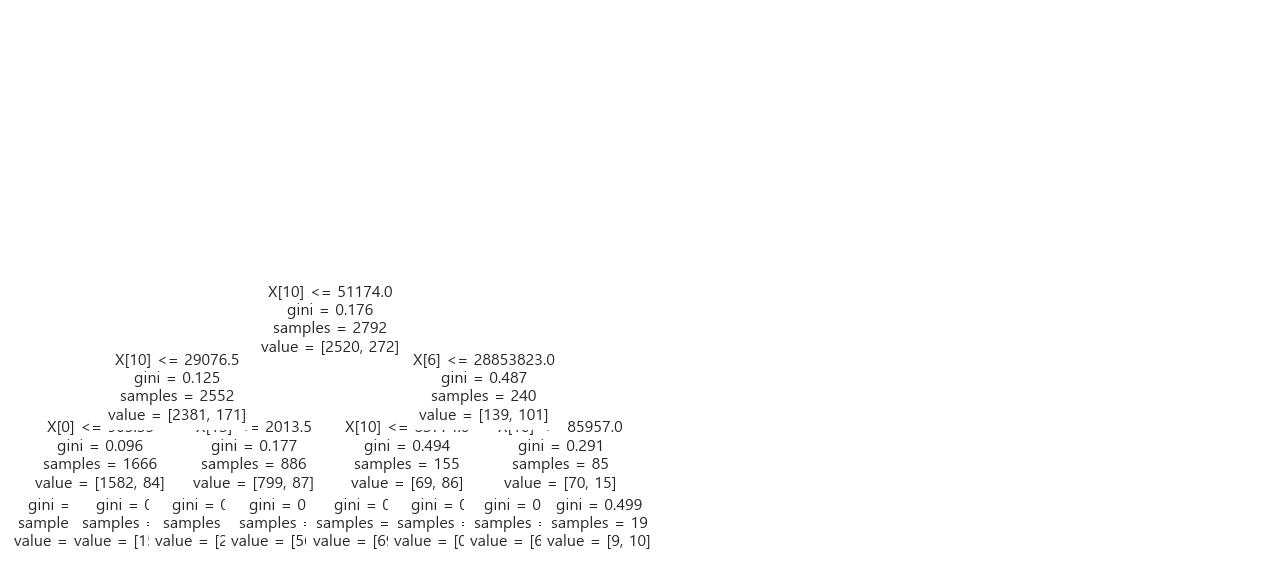

In [87]:
tree.plot_tree(dtc.fit(X_train,y_train))

In [88]:
X_train.columns

Index(['환율', '거래량', '기관합계', '기타법인', '개인', '외국인합계', '투자자예탁금', '외국인_시가총액',
       '외국인 비중', '기간자금설정', '기간자금해지', '증감', '유가증권신용거래융자', 'year', 'month'],
      dtype='object')

[]

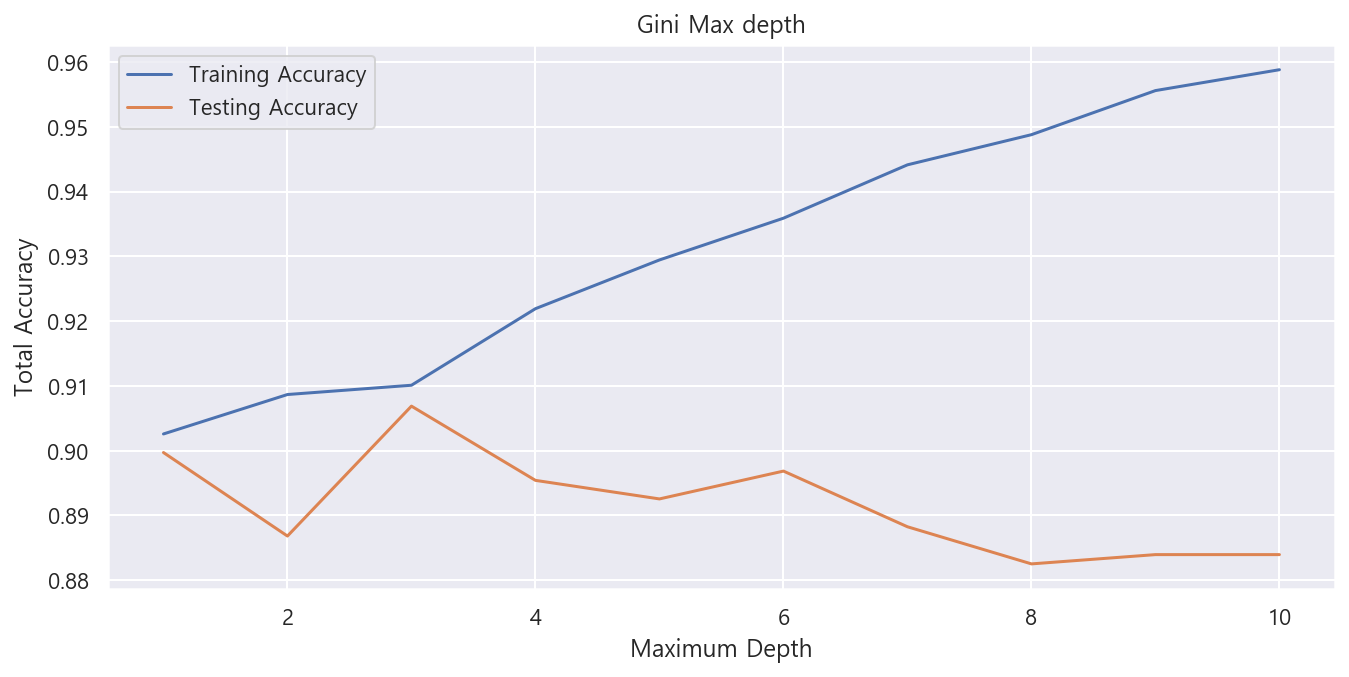

In [83]:
# 최적의 max depth 찾기
from sklearn.metrics import accuracy_score 
max_depth_list = [1,2,3,4, 5, 6, 7, 8, 9, 10]

train_errors = [] # Log training errors for each model
test_errors = [] # Log testing errors for each model

for x in max_depth_list:
    dtc = tree.DecisionTreeClassifier(max_depth=x, criterion='gini', random_state=1) 
    dtc.fit(X_train,y_train)
    train_z = dtc.predict(X_train)
    test_z = dtc.predict(X_test)
    train_errors.append(accuracy_score(y_train, train_z))
    test_errors.append(accuracy_score(y_test, test_z))

x = np.arange(len(max_depth_list)) + 1 # Create domain for plot
plt.plot(x, train_errors, label='Training Accuracy') # Plot training error over domain
plt.plot(x, test_errors, label='Testing Accuracy') # Plot testing error over domain
plt.xlabel('Maximum Depth') # Label x-axis
plt.ylabel('Total Accuracy') # Label y-axis
plt.legend() # Show plot labels as legend
plt.title('Gini Max depth')
plt.plot() # Show graph

In [89]:
# feature importance
feat_importance = dtc.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))
d = pd.DataFrame(feat_importance).rename(columns={0:'fe'})

feat importance = [0.00064631 0.         0.         0.         0.         0.
 0.00562967 0.         0.         0.         0.02583803 0.
 0.         0.00167328 0.        ]


Text(0.5, 1.0, 'Decision Tree Feature Importance')

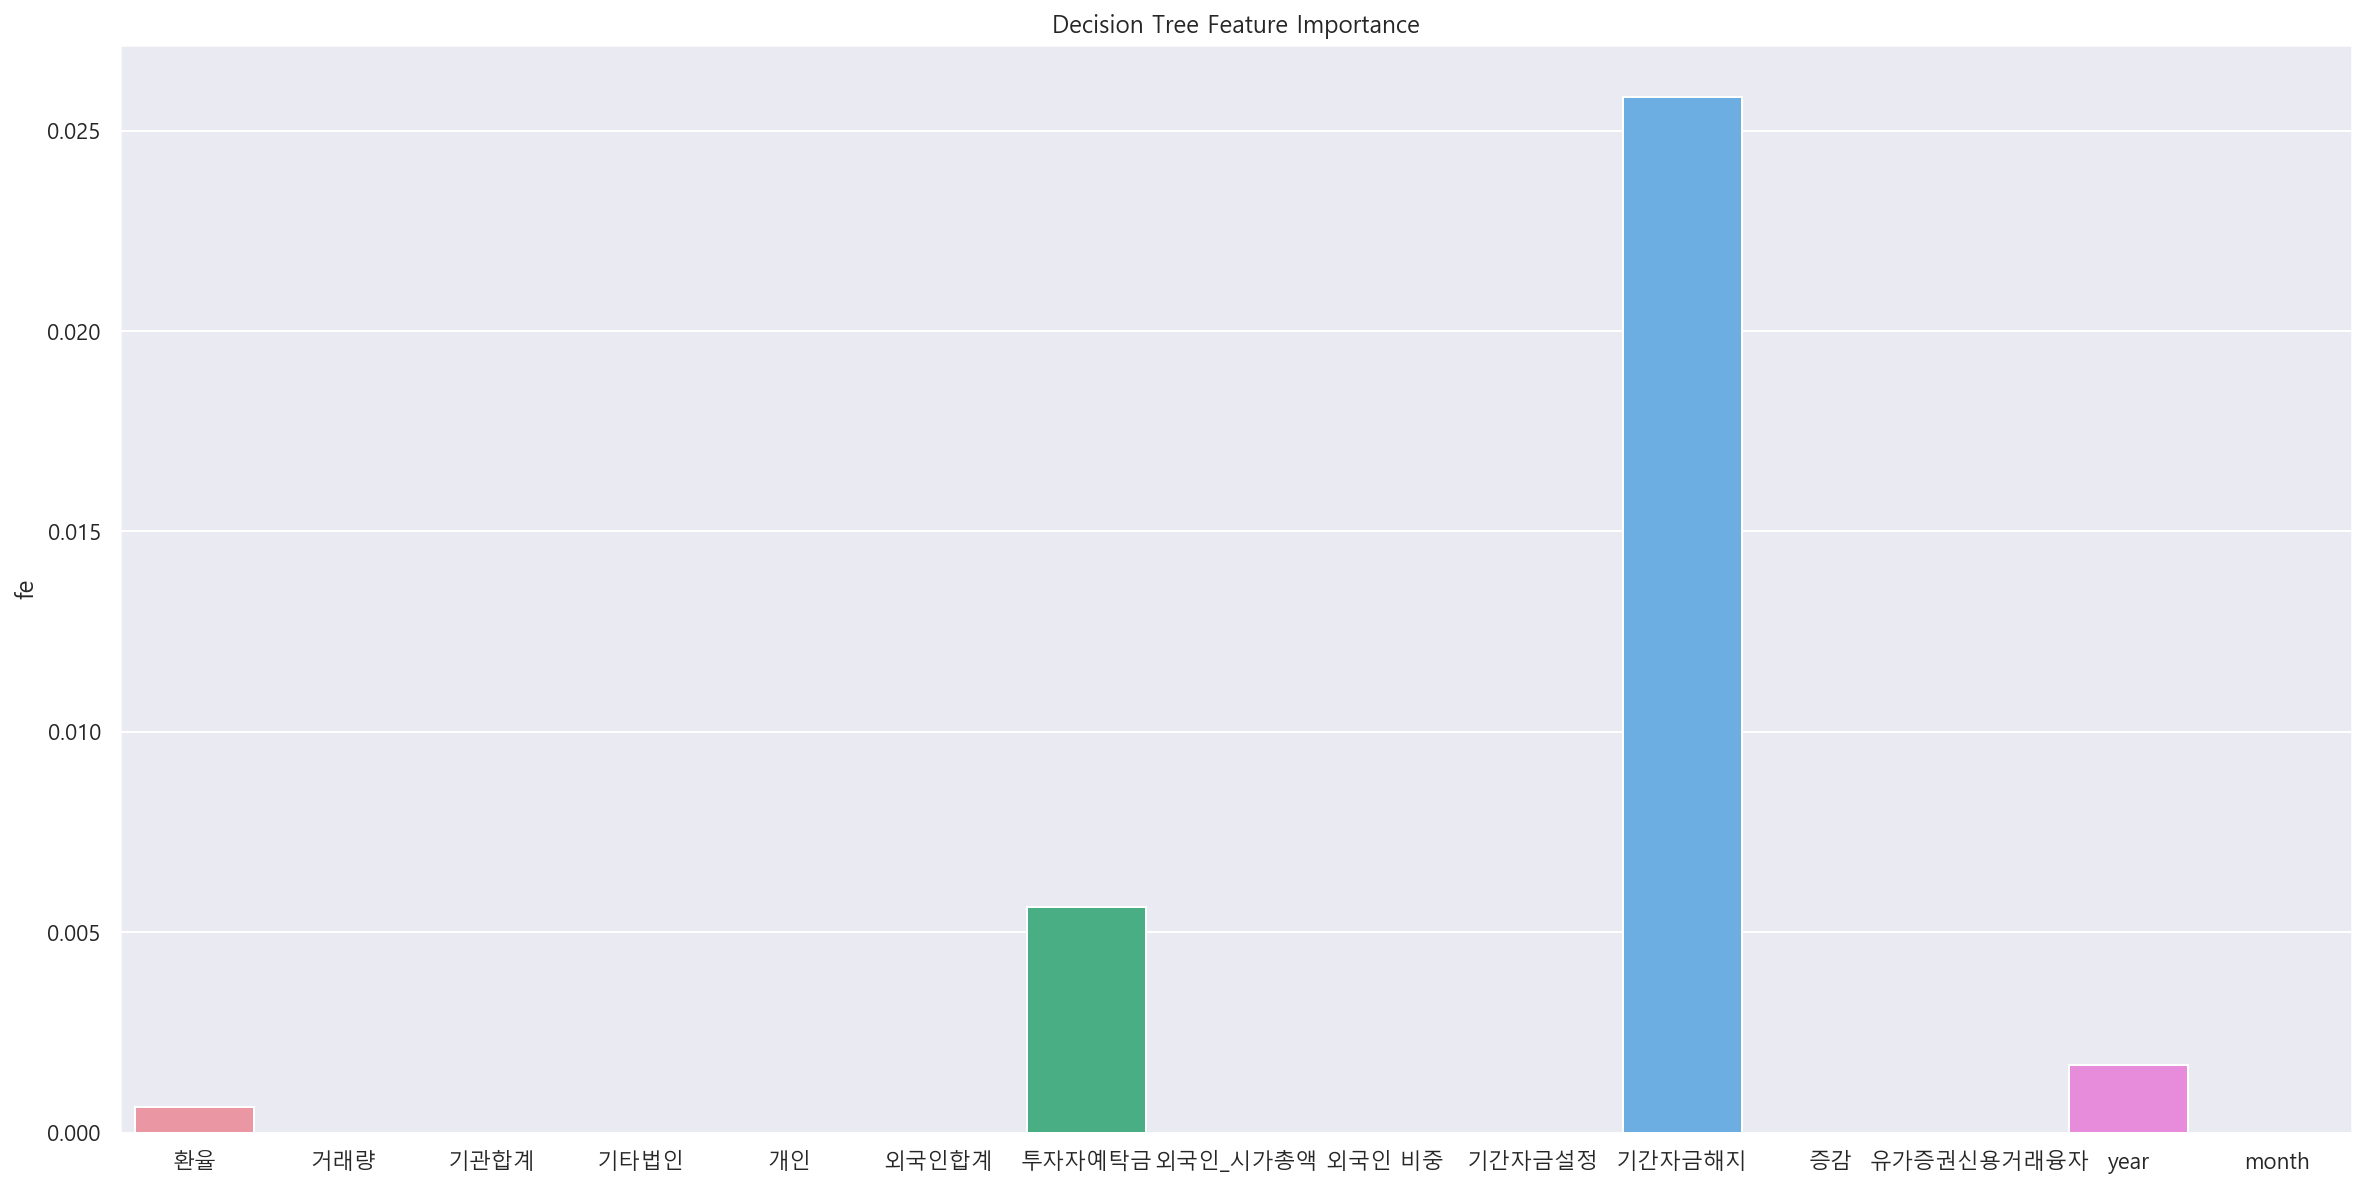

In [95]:
fig = plt.figure(figsize=(20,10))
sns.barplot(x=X_train.columns, y=d['fe'])
# plt.axhline(y=3556.315946, color='r', linewidth=2)
plt.title('Decision Tree Feature Importance')

기간자금해지와 투자자예탁금이 분류에 가장 큰 영향을 미치고있다.     
그리고 year도 어느정도 contribute를 하고있는 것을 보아 시계열적인 영향도 배제할 수 없을 듯 하다
> **기간자금해지 관련 factor**가 영향을 가장 크게 미치고있고, 이 때문에 깊이를 3으로만 뻗어도 이 기간자금해지율 때문에 잘 분류한다